
1. **SARIMA and SARIMAX Analysis**:
   - Data visualization (plotting the time series).
   - Stationarity check and making the series stationary if needed.
   - ACF and PACF plots to determine AR and MA terms.
   - SARIMA model training and prediction.
   - SARIMAX model if exogenous variables are needed.
   


2. **Facebook Prophet**:
   - Preparing the data for Prophet (renaming columns).
   - Model fitting and forecasting.
   - Visualizing the predictions.
   


3. **Recurrent Neural Networks (RNNs)**:
   - Data preprocessing for RNNs.
   - Building and training the RNN model.
   - Predictions and evaluation.
   
Let's start with the first part: SARIMA and SARIMAX analysis.



# <a id='toc1_'></a>[Time Series Analysis of COVID](#toc0_)

Models Deployed: ARIMA, SARIMA, SARIMAX, Facebook Prophet, and RNNs
In this notebook, we'll walk through different methods of time series analysis and forecasting using the provided dataset.


**Table of contents**<a id='toc0_'></a>    
- [Time Series Analysis of COVID](#toc1_)    
- [Focused Analysis](#toc2_)    
    - [Visualizing the Data](#toc2_1_1_)    
    - [Checking Stationarity](#toc2_1_2_)    
    - [BoxCox Transformation and Normality Test](#toc2_1_3_)    
    - [Seasonality](#toc2_1_4_)    
    - [ACF and PACF plots](#toc2_1_5_)    
    - [Time Series Cross-Validation Setup](#toc2_1_6_)    
- [Modeling](#toc3_)    
  - [Function for evaluating the model](#toc3_1_)    
  - [ARIMA](#toc3_2_)    
    - [Base Arima Model](#toc3_2_1_)    
    - [Tuned Arima Model](#toc3_2_2_)    
  - [SARIMA](#toc3_3_)    
    - [Base SARIMA Model](#toc3_3_1_)    
    - [Tuned SARIMA Model](#toc3_3_2_)    
  - [Sarimax](#toc3_4_)    
    - [Sarimax Base](#toc3_4_1_)    
    - [Tuned SARIMAX Model](#toc3_4_2_)    
  - [Prophet Model](#toc3_5_)    
    - [Prophet Base](#toc3_5_1_)    
    - [Prophet Tuned Model](#toc3_5_2_)    
    - [Facebook Prophet Analysis](#toc3_5_3_)    
      - [Preparing Data for Prophet](#toc3_5_3_1_)    
    - [Recurrent Neural Networks (RNNs)](#toc3_5_4_)    
      - [Data Preprocessing for RNNs](#toc3_5_4_1_)    
      - [Building and Training the RNN](#toc3_5_4_2_)    
      - [Predictions and Evaluation](#toc3_5_4_3_)    
- [Code of the dead](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


# <a id='toc2_'></a>[Focused Analysis](#toc0_)



### <a id='toc2_1_1_'></a>[Visualizing the Data](#toc0_)

First, let's visualize the time series data to understand its patterns and trends.


In [1]:
from capstone_functions import *
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('seaborn')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



KeyboardInterrupt: 

In [ ]:

# Load the dataset
master_df = pd.read_parquet("../Data/master_df.parquet")
master_df = pd.concat([master_df, create_features(master_df).drop(columns=['season','weekday','weekofyear', 'hour'])], axis=1).copy()
master_df['new_bi_weekly_vaccinations'] = master_df.loc[:,'total_vaccinations'].diff(15).fillna(0)

# Set the random.seed(42)
np.random.seed(42)

# sns.set_style('538')
master_df.info()
master_df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2020-02-15 to 2023-03-21
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         1131 non-null   int32  
 1   new_fatal                             1131 non-null   int32  
 2   confirmed                             1131 non-null   int32  
 3   fatal                                 1131 non-null   int32  
 4   infected                              1131 non-null   int32  
 5   new_recovered                         1131 non-null   int32  
 6   recovered                             1131 non-null   int32  
 7   total_removed                         1131 non-null   int32  
 8   new_hospitalized_patients             944 non-null    float32
 9   current_hospitalized_patients         1131 non-null   float32
 10  current_intensive_care_patients       1131 non-null   float32
 11 

,new_confirmed,new_fatal,confirmed,fatal,infected,new_recovered,recovered,total_removed,new_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,average_temperature_celsius,cancel_events,cumulative_hospitalized_patients,derived_reproduction_rate,dew_point,excess_mortality,excess_mortality_cumulative,excess_mortality_cumulative_absolute,facial_coverings,gatherings_restrictions,information_campaigns,internal_movement_restrictions,international_movement_restrictions,kap_mortality_rate,...,rho_transmission_rate,school_closing,sig_recovery_rate,snowfall_mm,stay_home_restrictions,stringency_index,susceptible,t/k_mortality_period,t/r_infection_period,t/s_recovery_period,testing_policy,tests_per_case,total_boosters,total_tests,total_vaccinations,transport_closing,vaccination_policy,workplace_closing,dayofweek,quarter,month,year,dayofyear,dayofmonth,new_bi_weekly_vaccinations
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,0,0,15,0,15,0,0,0,0.0,0.0,0.0,0.956790,0.0,0.0,35.466824,-6.882716,-2.363827,-3.049970,-12854.276367,0.0,0.0,0.0,0.0,3.0,0.000149,...,0.008729,0.0,0.000097,0.0,0.0,8.33,326687488.0,279.384735,4.773121,429.58667,1.0,9.3,0.0,139.5,0.0,0.0,0.0,0.0,5,1,2,2020,46,15,0.0
2020-02-16,0,0,15,0,15,0,0,0,0.0,0.0,0.0,3.919753,0.0,0.0,34.655106,-5.919753,-2.360000,-3.030000,-13024.399414,0.0,0.0,0.0,0.0,3.0,0.000155,...,0.008742,0.0,0.000097,0.0,0.0,8.33,326687488.0,268.378815,4.766480,429.58667,1.0,9.3,0.0,279.0,0.0,0.0,0.0,0.0,6,1,2,2020,47,16,0.0
2020-02-17,10,0,25,0,25,0,0,0,0.0,0.0,0.0,6.197531,0.0,0.0,33.889042,-0.481481,-2.294236,-3.005807,-13172.550781,0.0,0.0,0.0,0.0,3.0,0.000161,...,0.008749,0.0,0.000097,0.0,0.0,8.33,326687488.0,258.510406,4.762334,429.58667,1.0,9.3,0.0,511.5,0.0,0.0,0.0,0.0,0,1,2,2020,48,17,0.0
2020-02-18,0,0,25,0,25,0,0,0,0.0,0.0,0.0,0.592593,0.0,0.0,33.163906,-5.759259,-2.166535,-2.977392,-13298.730469,0.0,0.0,0.0,0.0,3.0,0.000167,...,0.008752,0.0,0.000097,0.0,0.0,8.33,326687488.0,249.624802,4.760667,429.58667,1.0,9.3,0.0,744.0,0.0,0.0,0.0,0.0,1,1,2,2020,49,18,0.0
2020-02-19,0,0,25,0,25,0,0,0,0.0,0.0,0.0,-2.753086,0.0,0.0,32.475555,-7.364198,-1.976897,-2.944754,-13402.938477,0.0,0.0,0.0,0.0,3.0,0.000172,...,0.008751,0.0,0.000097,0.0,0.0,8.33,326687488.0,241.594635,4.761477,429.58667,1.0,9.3,0.0,976.5,0.0,0.0,0.0,0.0,2,1,2,2020,50,19,0.0


In [ ]:
no_null_rows = master_df.dropna().copy()

no_null_rows.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 855 entries, 2020-02-15 to 2022-06-18
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         855 non-null    int32  
 1   new_fatal                             855 non-null    int32  
 2   confirmed                             855 non-null    int32  
 3   fatal                                 855 non-null    int32  
 4   infected                              855 non-null    int32  
 5   new_recovered                         855 non-null    int32  
 6   recovered                             855 non-null    int32  
 7   total_removed                         855 non-null    int32  
 8   new_hospitalized_patients             855 non-null    float32
 9   current_hospitalized_patients         855 non-null    float32
 10  current_intensive_care_patients       855 non-null    float32
 11  

In [ ]:
no_null_col = master_df.dropna(axis=1).copy()

no_null_col.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1131 entries, 2020-02-15 to 2023-03-21
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   new_confirmed                         1131 non-null   int32  
 1   new_fatal                             1131 non-null   int32  
 2   confirmed                             1131 non-null   int32  
 3   fatal                                 1131 non-null   int32  
 4   infected                              1131 non-null   int32  
 5   new_recovered                         1131 non-null   int32  
 6   recovered                             1131 non-null   int32  
 7   total_removed                         1131 non-null   int32  
 8   current_hospitalized_patients         1131 non-null   float32
 9   current_intensive_care_patients       1131 non-null   float32
 10  cancel_events                         1131 non-null   float32
 11 

In [ ]:
cutoff=28

cutoff_date = no_null_col.index.max() - pd.Timedelta(days=cutoff)

train_df = no_null_col[no_null_col.index < cutoff_date].copy()
test_df = no_null_col[no_null_col.index >= cutoff_date].copy()


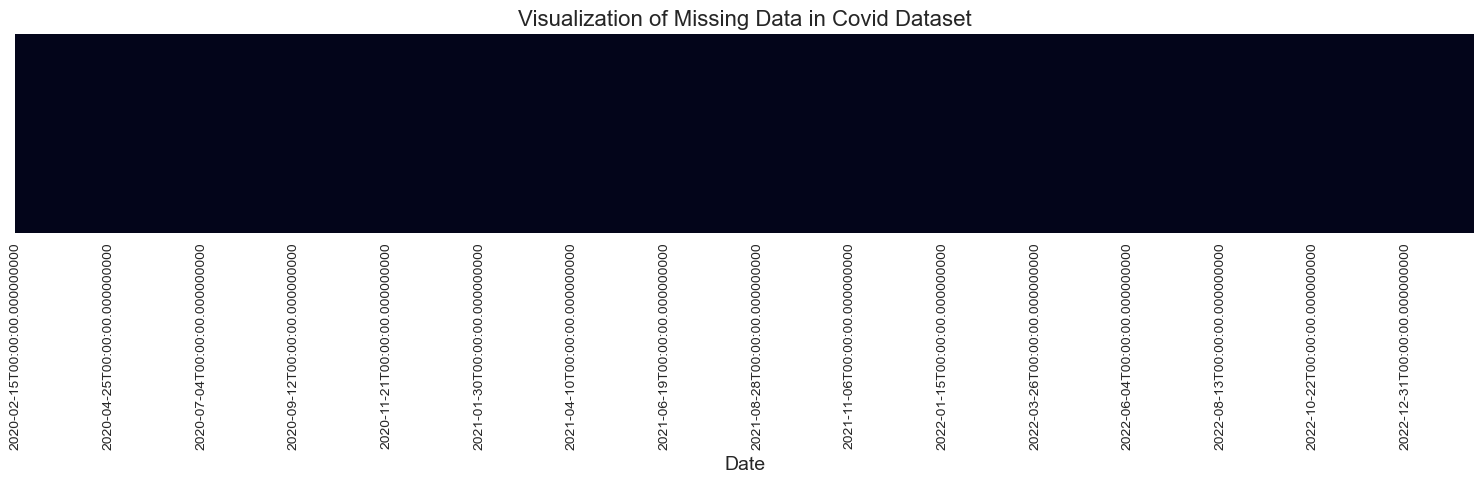

In [ ]:
# Your existing code
plt.figure(figsize=(15,5))
sns.heatmap(train_df.isna().T, yticklabels=[], cbar=False)

# Setting x-axis to show every 3 months and starting from 2020-02-15
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticks(xticks[::5])

plt.title("Visualization of Missing Data in Covid Dataset", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Creating subplots vertically aligned
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Daily Confirmed Cases", "Currently Infected", "Total Confirmed"))

# Adding traces for the train dataset
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['new_confirmed'], name='New Confirmed (Train)', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['infected'], name='Currently Infected (Train)', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['confirmed'], name='Total Confirmed (Train)', line=dict(color='blue')), row=3, col=1)

# Adding traces for the test dataset
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['new_confirmed'], name='New Confirmed (Test)', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['infected'], name='Currently Infected (Test)', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['confirmed'], name='Total Confirmed (Test)', line=dict(color='red')), row=3, col=1)

# Update the layout
fig.update_layout(height=800, 
                width=1000, 
                title='Daily Confirmed Cases, Currently Infected, and Total Confirmed',
                xaxis_rangeslider_visible=False)
fig.update_xaxes(title_text='Date', row=3, col=1)
fig.update_yaxes(title_text='New Confirmed Cases', row=1, col=1)
fig.update_yaxes(title_text='Currently Infected', row=2, col=1)
fig.update_yaxes(title_text='Total Confirmed', row=3, col=1)



### <a id='toc2_1_2_'></a>[Checking Stationarity](#toc0_)
Before applying ARIMA or its variants, it's essential to ensure our time series is stationary.


In [ ]:
def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value','Number of Observations Used'])
    return dfoutput


test_stationarity(train_df['confirmed'])

# # Display the collected test statistics for each differencing level
# for i, test_stat in enumerate(test_statistics, 1):
#     print(f"Differencing Level {i}: Test Statistic = {test_stat:.2f}")

Results of Dickey-Fuller Test:


Test Statistic                   -0.002479
p-value                           0.958327
#Lags Used                       22.000000
Number of Observations Used    1079.000000
Critical Value (1%)              -3.436425
Critical Value (5%)              -2.864222
Critical Value (10%)             -2.568198
dtype: float64


If the `p-value` is less than 0.05, the series is stationary. Otherwise, you might need to take differences or transformations to make it stationary.


In [ ]:
# List to collect the 'Test Statistic' values for each differencing level
test_statistics = []

# Iterate over possible differencing levels from 1 to 19
for i in range(1, 20):
    # Difference the 'confirmed' series by the current level and drop NA values
    differenced_series = train_df['confirmed'].diff(i).dropna()
    
    # Get the test statistic from the stationarity check and append to the list
    test_stat = check_stationarity(differenced_series).loc['Test Statistic']
    test_statistics.append(test_stat)

# Display the collected test statistics for each differencing level
for i, test_stat in enumerate(test_statistics, 1):
    print(f"Differencing Level {i}: Test Statistic = {test_stat:.2f}")

Differencing Level 1: Test Statistic = -4.75
Differencing Level 2: Test Statistic = -4.41
Differencing Level 3: Test Statistic = -4.36
Differencing Level 4: Test Statistic = -3.59
Differencing Level 5: Test Statistic = -3.83
Differencing Level 6: Test Statistic = -3.53
Differencing Level 7: Test Statistic = -3.46
Differencing Level 8: Test Statistic = -3.11
Differencing Level 9: Test Statistic = -2.91
Differencing Level 10: Test Statistic = -3.13
Differencing Level 11: Test Statistic = -2.93
Differencing Level 12: Test Statistic = -3.30
Differencing Level 13: Test Statistic = -3.90
Differencing Level 14: Test Statistic = -4.08
Differencing Level 15: Test Statistic = -4.41
Differencing Level 16: Test Statistic = -3.50
Differencing Level 17: Test Statistic = -3.57
Differencing Level 18: Test Statistic = -3.62
Differencing Level 19: Test Statistic = -3.66


In [ ]:
test_stationarity(train_df['new_confirmed'])


Results of Dickey-Fuller Test:


Test Statistic                   -4.747711
p-value                           0.000068
#Lags Used                       21.000000
Number of Observations Used    1080.000000
Critical Value (1%)              -3.436419
Critical Value (5%)              -2.864220
Critical Value (10%)             -2.568197
dtype: float64

### <a id='toc2_1_3_'></a>[BoxCox Transformation and Normality Test](#toc0_)

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\utils\visualization.py:220: FutureWarning:

the 'unbiased' keyword is deprecated, use 'adjusted' instead.



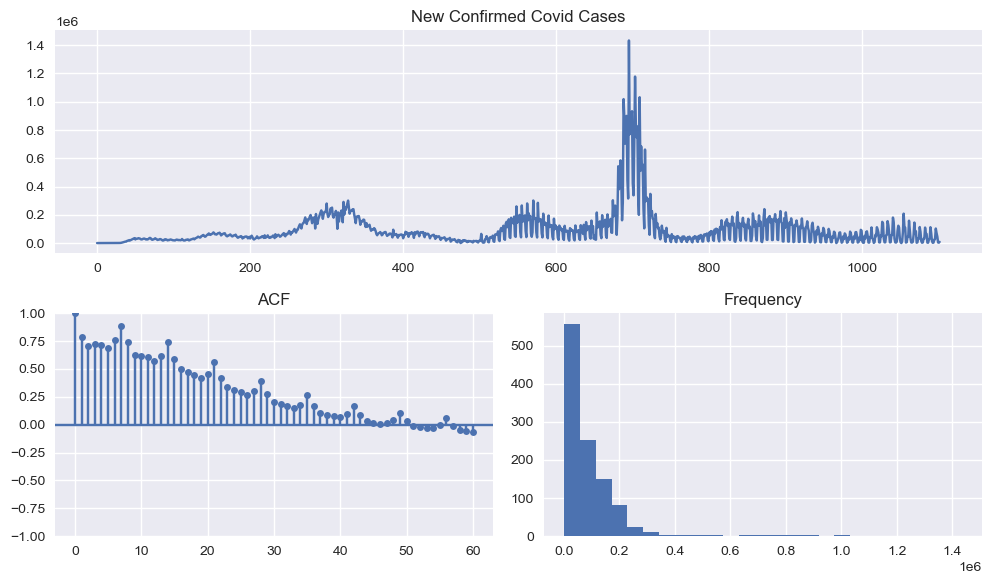

In [ ]:
# sns.histplot(data = train_df, x='new_confirmed', bins=100, kde=True);

pm.tsdisplay(train_df['new_confirmed'], title="New Confirmed Covid Cases", lag_max=60, figsize=(10, 6));


C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\utils\visualization.py:220: FutureWarning:

the 'unbiased' keyword is deprecated, use 'adjusted' instead.



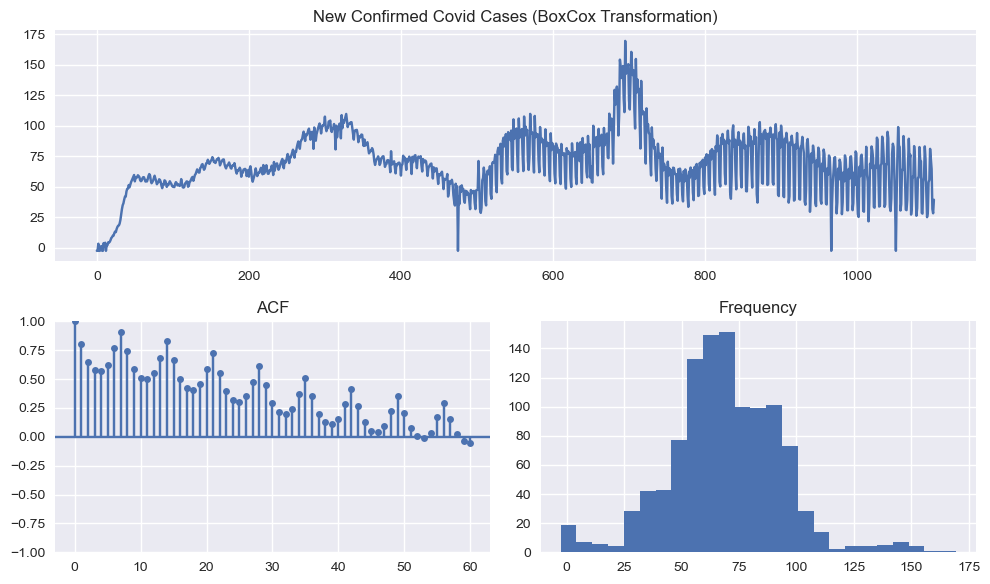

In [ ]:
boxcox = BoxCoxEndogTransformer(lmbda2=1e-6)
covid_array = boxcox.fit_transform(train_df['new_confirmed'])[0]
covid_transformed = pd.Series(covid_array, index=train_df.index)

pm.tsdisplay(covid_transformed, title="New Confirmed Covid Cases (BoxCox Transformation)", lag_max=60, figsize=(10, 6))


### <a id='toc2_1_4_'></a>[Seasonality](#toc0_)

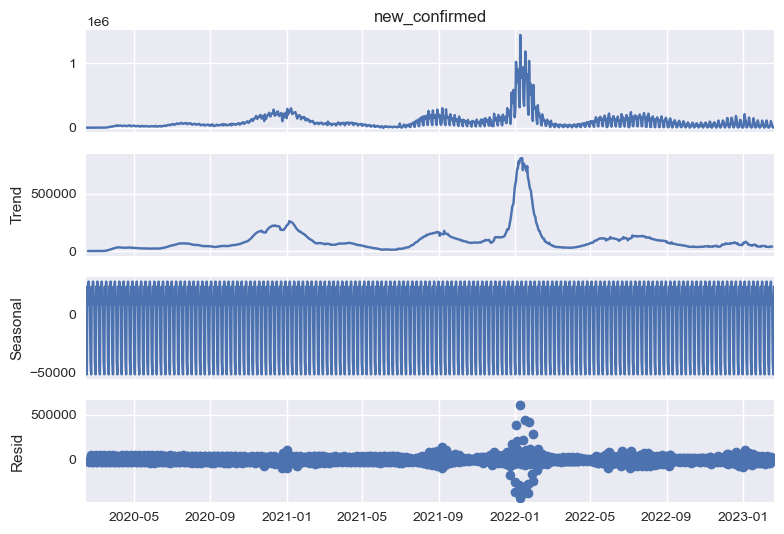

In [ ]:
# Performing seasonal decomposition on 'new_confirmed' column
tsa.seasonal_decompose(train_df['new_confirmed'], model='additive', period=7).plot();


This is a little difficult for me to understand, except to say that there really doesn't appear to be much of a seasonal component.

In [ ]:
features, target = create_features(train_df, label='new_confirmed')
features_and_target = pd.concat([features, target], axis=1)

features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,new_confirmed
date,,,,,,,,,,,
2020-02-15,0,5,1,2,2020,46,15,7,Saturday,Winter,0
2020-02-16,0,6,1,2,2020,47,16,7,Sunday,Winter,0
2020-02-17,0,0,1,2,2020,48,17,8,Monday,Winter,10
2020-02-18,0,1,1,2,2020,49,18,8,Tuesday,Winter,0
2020-02-19,0,2,1,2,2020,50,19,8,Wednesday,Winter,0


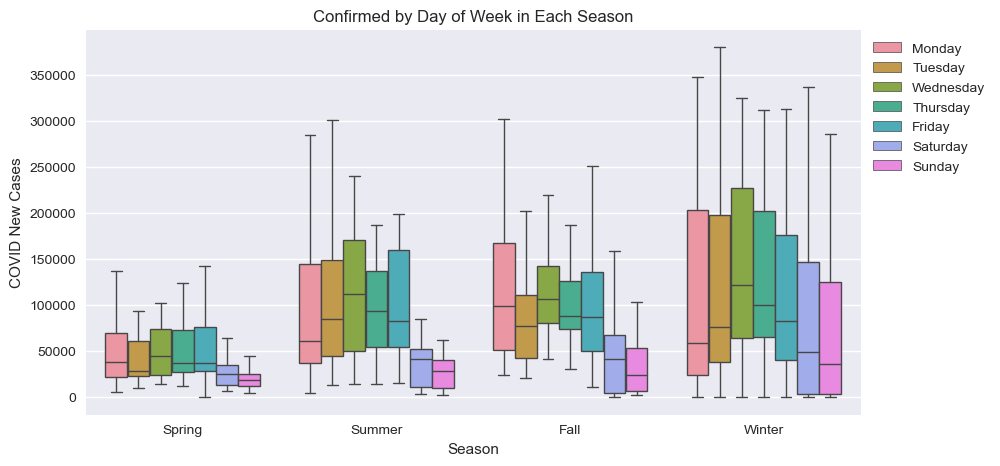

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='season',
            y='new_confirmed',
            hue='weekday',
            ax=ax,
            linewidth=1,
            showfliers=False)
ax.set_title('Confirmed by Day of Week in Each Season')
ax.set_xlabel('Season')
ax.set_ylabel('COVID New Cases')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


### <a id='toc2_1_5_'></a>[ACF and PACF plots](#toc0_)

To determine the order of the AR and MA terms, we can plot the autocorrelation and partial autocorrelation charts.


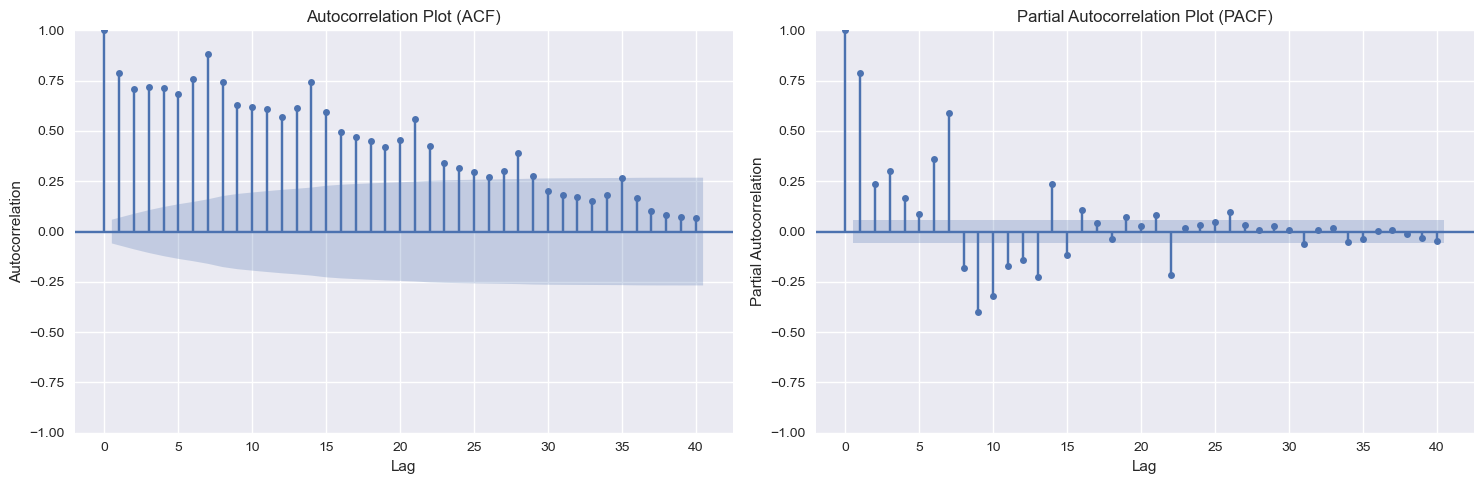

In [ ]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(train_df['new_confirmed'].dropna(), lags=40, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(train_df['new_confirmed'].dropna(), lags=40, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


From the PACF it looks like our auto regressive model would only benefit by a maximum of 15-16 days. We will use this as our base p value.  
From our ACF graph it looks like our moving average model would only benefit by a maximum of 25-28 days. We will use this as our base q value.  

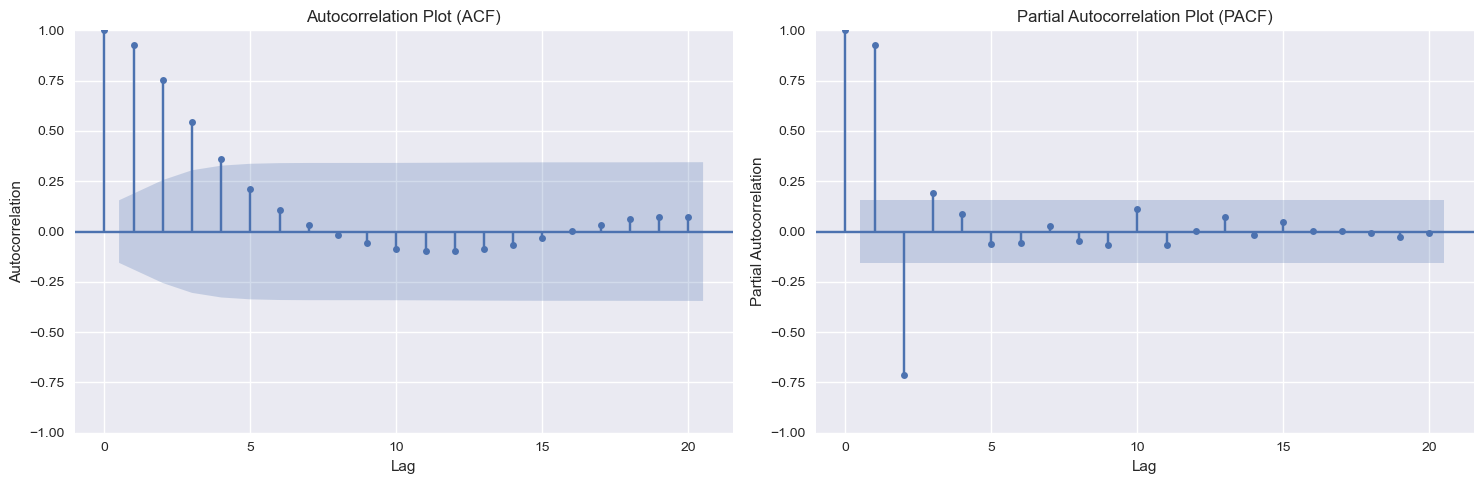

In [ ]:
weekly_mean = train_df.resample('W').mean()


# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(weekly_mean['new_confirmed'].dropna(), lags=20, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(weekly_mean['new_confirmed'].dropna(), lags=20, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


### <a id='toc2_1_6_'></a>[Time Series Cross-Validation Setup](#toc0_)

In [ ]:
def plot_cross_val(df: pd.DataFrame,
                    title_text: str,
                    fold_size: int,
                    adjustment: int,
                    rolling: bool=False,
                    window_size: int=150,
                    initial_size: int=200) -> pd.DataFrame:
    """
    Visualize the train and test splits of cross-validation using Plotly.
    
    This function generates a visual representation of how data is split into 
    training and testing sets across multiple iterations of a cross-validation 
    process. It's particularly useful for understanding the behavior of different 
    cross-validation strategies, such as KFold or TimeSeriesSplit.
    
    Parameters:
    - n_splits (int): Number of splits for cross-validation.
    - splitter_func (callable): Cross-validation splitting strategy (e.g., KFold, TimeSeriesSplit).
    - df (pd.DataFrame): Dataframe whose index is to be used for splitting.
    - title_text (str): Title of the plot.
    
    Returns:
    - plot_df (pd.DataFrame): DataFrame with indices used for each split and their corresponding labels.
    """
    
    split = 1
    plot_data = []

    if rolling:
    # Iterate through train and test splits provided by the splitter function
    
        rolling_cv = RollingForecastCV(
            h=fold_size,            # Forecast horizon (28 step ahead)
            step=fold_size+adjustment,         # Step size for rolling window (28 step at a time)
            initial=initial_size)   # Skip the first 20 observations for warm-up
        for train_index, valid_index in rolling_cv.split(df):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1
    else:
        window_cv = pm.model_selection.SlidingWindowForecastCV(
            window_size=window_size,         # Window size (150 observations)
            h=fold_size,             # Forecast horizon (28 step ahead)
            step=fold_size+adjustment)          # Step size for rolling window (28 step at a time)
        # Iterate through train and test splits provided by the splitter function
        
        for train_index, valid_index in window_cv.split(df):
            plot_data.append([train_index, 'Train', f'{split}'])
            plot_data.append([valid_index, 'Test', f'{split}'])
            split += 1
    
    # Create a DataFrame to hold the indices for plotting
    plot_df = pd.DataFrame(plot_data, columns=['Index', 'Dataset', 'Split']).explode('Index')
    plot_df['Split'] = plot_df['Split'].astype(int)
    plot_df = plot_df.sort_values('Split')

    # Initialize a Plotly figure
    fig = go.Figure()

    # Add traces for each train and test split
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                y=group['Split'].loc[group['Dataset'] == 'Train'],
                                name='Train',
                                line=dict(color="blue", width=10)
                                ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                y=group['Split'].loc[group['Dataset'] == 'Test'],
                                name='Test',
                                line=dict(color="goldenrod", width=10)
                                ))

    # Configure plot layout
    fig.update_layout(template="simple_white", 
                    font=dict(size=20),
                    title_text=title_text, 
                    title_x=0.5, width=850,
                    height=450, 
                    xaxis_title='Index', 
                    yaxis_title='Split')

    # Update legend to avoid duplicate entries
    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))
    fig.show()
    

In [ ]:
in_sample_set = train_df['new_confirmed']
out_of_sample_set = test_df['new_confirmed']

number_of_folds = 10

fold_size = int(((len(in_sample_set)-200)/number_of_folds)-round(82/number_of_folds))
adjustment=0

print("Fold Size =", fold_size)


rolling_cv = RollingForecastCV(
    h=fold_size,  # Forecast horizon (28 step ahead)
    step=fold_size+adjustment,  # Step size for rolling window (28 step at a time)
    initial=200)  # Skip the first 20 observations for warm-up


# Plot the time series cross validation splits
plot_cross_val(in_sample_set,
            'Time Series Rolling Forecast Cross-Validation',
            fold_size,
            rolling=True, 
            adjustment=adjustment)

window_cv = pm.model_selection.SlidingWindowForecastCV(
    window_size=150, # Window size (150 observations)
    h=fold_size,  # Forecast horizon (28 step ahead)
    step=fold_size+adjustment)  # Step size for rolling window (28 step at a time)

# Plot the time series cross validation splits
plot_cross_val(in_sample_set,
            'Time Series Sliding Window Cross-Validation',
            fold_size,
            rolling=False, 
            adjustment=adjustment)

Fold Size = 82


# <a id='toc3_'></a>[Modeling](#toc0_)

## <a id='toc3_1_'></a>[Function for evaluating the model](#toc0_)

Creating Functions for Time Series Evaluation

In [ ]:
from matplotlib.ticker import FuncFormatter, PercentFormatter

# Format right y-axis with comma notation
def comma_format(x, _):
    return f'{x:,.0f}'

def mape(actual, pred):
    return 100 * np.mean(np.abs(actual - pred) / (np.abs(actual+1)))

def smape(actual, pred):
    return 100 * np.mean(np.abs(actual - pred) / (np.abs(actual) + np.abs(pred)))

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))


In [ ]:
# # Flag to determine if the model should be trained or loaded from disk
# training = True

# # Check if the training flag is set to True
# if training:
    
#     # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
#     estimators = [
#         ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
#         ("model", REPLACETHIS)) # ARIMA model                   
#                         ]
#     pipeline = Pipeline(estimators)

# else:
#     # If not training, then load the pre-trained model from disk
#     REPLACETHIS = joblib.load('models/REPLACETHIS intercept.pkl')
#     print("REPLACETHIS loaded successfully")


# if training:
#     # If in training mode:
    
#     # Train the model using the specified pipeline and cross-validation window
#     daily_values, val_scores, REPLACETHIS = train_model(in_sample_set, pipeline, rolling_cv)

#     # Visualize the model's performance on the validation set
#     plot_combined_charts(daily_values, val_scores, in_sample_set.name)


# # Visualize the model's in-sample predictions with confidence intervals
# in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, REPLACETHIS)

# # Evaluate the model's forecasting performance on the out-of-sample data
# test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, REPLACETHIS)

# # Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
# model_name = str(REPLACETHIS.steps[-1][1]).strip()

# # Store evaluation metrics in their respective dictionaries
# val_eval_holder[model_name] = val_scores.mean()
# in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores

# # Display evaluation results
# display(val_eval_holder)
# display(in_sample_eval_holder)
# # display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


# if training:
#     # If in training mode:
    
#     # Define the path where the trained model will be pickled (saved) to
#     pickle_tgt = f"models/{model_name}.pkl"
    
#     try:
#         # Attempt to save the model to disk using pickling
#         joblib.dump(REPLACETHIS, pickle_tgt, compress=3)
#         print("Model pickled to %s" % pickle_tgt)
        
#     except:
#         # If there's an error during pickling, display an error message
#         print("Error pickling model")


# # Display the summary of the trained model
# REPLACETHIS.summary()

In [ ]:
def train_model(y: pd.Series, pipeline, cv, X: pd.DataFrame=None):
    """
    Train a model on the given data and generate predictions.
    
    Parameters:
    - y: DataFrame containing the training data.
    - pipeline: Preprocessing pipeline for the data.
    - cv: Cross-validator for time series data.
    
    Returns:
    - model_preds: Series of model predictions.
    - model_scores: DataFrame containing the scores for various metrics.
    """
    model_preds_data = {
        'predicted': [],  # predicted values
        'lower_conf': [], # lower confidence interval
        'upper_conf': [], # upper confidence interval
        'date': [] # date of prediction
    }
    
    # model_mape_score = pd.Series(name='mape')
    model_smape_score = pd.Series(name='smape')
    model_rmse_score = pd.Series(name='rmse')
    model_mae_score = pd.Series(name='mae')
    
    for train_idx, test_idx in tqdm(cv.split(y)):
        train_set = y.iloc[train_idx]
        test_set = y.iloc[test_idx]
        
        train_exogenous = X.iloc[train_idx] if X is not None else None
        test_exogenous = X.iloc[test_idx] if X is not None else None
        
        assert not train_set.isna().any(), "train_set contains NaN values"
        assert not test_set.isna().any(), "test_set contains NaN values"
        
        model = pipeline.fit(train_set, train_exogenous)
        
        try:
            prediction, conf = model.predict(len(test_set), test_exogenous, return_conf_int= True)
        except:
            prediction = model.predict(len(test_set), test_exogenous)
            conf = np.full(shape=(len(test_set), 2), fill_value=prediction)
        lower_conf = conf[:,0]
        upper_conf = conf[:,1]
            
        model_preds_data['predicted'].extend(prediction)
        model_preds_data['lower_conf'].extend(lower_conf)
        model_preds_data['upper_conf'].extend(upper_conf)
        model_preds_data['date'].extend(test_set.index)
        
        first_date = test_set.index[0]
        model_smape_score[first_date] = smape(test_set, prediction)
        model_rmse_score[first_date] = rmse(test_set, prediction)
        model_mae_score[first_date] = np.mean(np.abs(test_set - prediction))
        # model_mape_score[first_date] = mape(test_set, prediction)
    
    # Generating Daily Metrics
    daily_metrics = pd.DataFrame(model_preds_data)
    daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])
    daily_metrics.set_index('date', inplace=True)
    daily_metrics = pd.concat([daily_metrics, y], axis=1, join='outer')
    daily_metrics['residual'] = daily_metrics[y.name] - daily_metrics['predicted']
    daily_metrics['smape'] =  100 * np.abs(daily_metrics[y.name] - daily_metrics['predicted']) / (np.abs(daily_metrics[y.name]) + np.abs(daily_metrics['predicted']))


    # Generating Model Scores on Validation Sets
    model_scores = pd.DataFrame(
        index=['MAE', 'RMSE', 'sMAPE'], 
        data=[model_mae_score, model_rmse_score, model_smape_score]
    ).T

    # Fitting the Model on the Entire Dataset
    model = pipeline.fit(y)

    return daily_metrics, model_scores, model



In [ ]:
def plot_combined_charts(daily_df: pd.DataFrame, validation_scores_df: pd.DataFrame, target_column: str) -> None:
    """
    Plot actual vs predicted values and evaluation metrics side by side.
    
    This function visualizes the actual vs predicted values and evaluation metrics 
    (MAPE, SMAPE, MAE, RMSE) side by side in a 1x2 grid.
    
    Parameters:
    - daily_df (pd.DataFrame): A dataframe containing the actual and predicted values.
    - validation_scores_df (pd.DataFrame): A dataframe with columns 'mape', 'smape', 'mae', and 'rmse'.
    - target_column (str): The name of the target column for which predictions are made.
    
    Returns:
    None. The function displays the plots.
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot Actual vs Predicted on the first axis
    daily_df[f'{target_column}'].plot(ax=ax1, label='Actual', linewidth=2)
    daily_df['predicted'].plot(ax=ax1, label='Cross-Validation Predicted', linestyle='--', linewidth=2)
    ax1.yaxis.set_major_formatter(FuncFormatter(comma_format))
    ax1.set_title(f'Cross Validation of {target_column.replace("_", " ").capitalize()}: Model Predictions vs Actual Data', fontsize=14)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # Plot Error Metrics on the second axis
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['MAE'], ax=ax2, label='MAE', color='b')
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['RMSE'], ax=ax2, label='RMSE', color='g')
    
    ax3 = ax2.twinx()
    sns.lineplot(x=validation_scores_df.index, y=validation_scores_df['sMAPE'], ax=ax3, label='sMAPE', color='purple', linestyle='--')
    ax2.set_ylabel('Absolute Error (Covid Cases)')
    ax3.set_ylabel('Percentage Error (Covid Cases)')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x/100)))
    ax3.set_ylim(0, 100)
    ax2.set_title('Cross-Validation Error Metrics: Error over Different Time Periods', fontsize=14)
    ax2.set_xlabel('Date')
    
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles3, labels3 = ax3.get_legend_handles_labels()
    ax2.legend(handles=handles2 + handles3, labels=labels2 + labels3, loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_predictions_with_confidence_interval(in_sample_set, model, X_train=None):
    """
    Plot actual versus predicted values along with the 95% confidence interval.
    
    This function takes the actual in-sample set and a fitted model to generate a plot
    showcasing the actual values, predicted values, and the confidence interval. It then
    calculates and returns evaluation metrics in a DataFrame.
    
    Parameters:
    - in_sample_set (pd.Series): The actual values.
    - model: The fitted model.
    
    Returns:
    pd.DataFrame: A dataframe containing evaluation metrics.
    """
    
    # Predict in-sample values and get confidence intervals
    predicted_values, conf_int = model.predict_in_sample(X=X_train, return_conf_int=True, start=60)
    in_sample_set = in_sample_set[60:]
    # Create a DataFrame for easier plotting and analysis
    df = pd.DataFrame({
        in_sample_set.name: in_sample_set, 
        'predicted_in_sample': predicted_values,
        'upper_conf': conf_int[:, 1],
        'lower_conf': conf_int[:, 0],
        'residuals': in_sample_set - predicted_values
    }, index=in_sample_set.index)

    # Initialize a Plotly figure for visualization
    fig = go.Figure()

    # Add traces for actual and predicted values, as well as confidence intervals
    fig.add_trace(go.Scatter(x=df.index, y=df[in_sample_set.name], mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df.index, y=df['predicted_in_sample'], mode='lines', name='Predicted', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=df.index, y=df['upper_conf'], mode='lines', line=dict(color='rgba(255, 0, 0, 0.3)', width=0), showlegend=False))
    fig.add_trace(go.Scatter(x=df.index, y=df['lower_conf'], mode='lines', name='95% Confidence Interval', line=dict(color='rgba(255, 0, 0, 0.3)', width=0), fill='tonexty'))

    # Update layout to include range sliders for better interactivity
    fig.update_layout(
        title='In-Sample Data vs. Predicted Values with Confidence Intervals',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=2, label="2y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        ),
        yaxis=dict(
            title="COVID New Case Count",
            rangemode="tozero"
        )
    )

    # Render the figure
    fig.show()

    # # Create the histogram plot for residuals
    # plt.figure(figsize=(10, 6))
    # sns.histplot(df['residuals'], kde=True, color="dodgerblue", bins=30)
    
    # # Set title and labels
    # plt.title('Distribution of Residuals', fontsize=16, fontweight='bold')
    # plt.xlabel('Residuals', fontsize=14)
    # plt.ylabel('Count', fontsize=14)
    
    # # Show the plot with a tight layout
    # plt.tight_layout()
    # plt.show()
    
    df['residuals'].plot_diagnostics(figsize=(15, 12))

    plt.show()
    print("Ljung-box p-values:\n" + str(df['residuals'].test_serial_correlation(method='ljungbox')[0][1]))
    res.summary()

    
    # Compute evaluation metrics
    r2 = r2_score(in_sample_set, predicted_values)
    mae = mean_absolute_error(in_sample_set, predicted_values)
    rmse = np.sqrt(mean_squared_error(in_sample_set, predicted_values))
    smape_val = smape(in_sample_set, predicted_values)

    # Create and return a DataFrame with the calculated metrics
    metrics_df = pd.DataFrame({
        'R-squared': [r2],
        'MAE': [mae],
        'RMSE': [rmse],
        'sMAPE': [smape_val]
    })

    return metrics_df.T


In [ ]:

def evaluate_forecast(in_sample_set, out_of_sample_set, model, X_test=None):
    """
    Evaluate the performance of an ARIMA forecast against out_of_sample_set values and visualize the results.
    
    This function computes multiple error metrics including MAE, RMSE, MAPE, and sMAPE. 
    It also visualizes the in_sample_set, out_of_sample_set, and predicted series for easier comparison 
    using Plotly.
    
    Parameters:
    - in_sample_set (pd.Series): Series containing in_sample_set values leading up to the forecast.
    - out_of_sample_set (pd.Series): Series containing the out_of_sample_set values for the time period being forecasted.
    - predicted (pd.Series): Series containing the predicted values from the ARIMA model.
    
    Returns:
    - metrics_df (pd.DataFrame): A DataFrame containing the calculated error metrics.
    """
    predicted, conf = model.predict(len(out_of_sample_set), X=X_test, return_conf_int= True)
    predicted = pd.Series(predicted, index=out_of_sample_set.index)
    lower_conf = conf[:,0]
    upper_conf = conf[:,1]    # Calculate daily error metrics
    
    daily_metrics = pd.DataFrame()
    daily_metrics['residual'] = out_of_sample_set - predicted
    daily_metrics['predicted'] =  predicted
    daily_metrics['out_of_sample_set'] =  out_of_sample_set
    daily_metrics['lower_conf'] =  lower_conf
    daily_metrics['upper_conf'] =  upper_conf
    
    
    
    # # Create a seaborn scatter plot
    # fig1 = go.Figure()

    # # Plot mae on the primary y-axis
    # fig1 = px.scatter(daily_metrics, x='predicted', y='residual', title="Predicted Values vs Residuals")
    # fig1.update_layout(title="Predicted Values vs Residuals", xaxis_title="Predicted Values")
    # fig1.update_yaxes(title_text="Residuals")
    # fig1.show()
    
    
    # Create a Plotly visualization to compare in_sample_set, out_of_sample_set, and predicted series
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(y=in_sample_set[-40:], x=in_sample_set.index[-40:], mode='lines', name='In Sample Set', line=dict(color='blue', width=2)))
    fig2.add_trace(go.Scatter(y=out_of_sample_set, x=out_of_sample_set.index, mode='lines', name='Out of Sample Set', line=dict(color='green', width=2)))
    fig2.add_trace(go.Scatter(y=predicted, x=predicted.index, mode='lines', name='Predicted', line=dict(color='red', width=2, dash='dash')))
    
    # Add upper and lower confidence intervals and fill between them
    fig2.add_trace(go.Scatter(x=predicted.index, y=upper_conf, mode='lines', name='Upper Confidence', line=dict(width=0), showlegend=False))
    fig2.add_trace(go.Scatter(x=predicted.index, y=lower_conf, mode='lines', name='Lower Confidence', line=dict(width=0), fill='tonexty', fillcolor='rgba(255,0,0,0.2)', showlegend=False))
    
    # Customize the layout of the plot
    fig2.update_layout(title="out_of_sample_set vs Predicted Values", 
                    xaxis_title="Date", 
                    yaxis_title="Value",
                    xaxis_rangeslider_visible=True)
    
    # Display the visualization
    fig2.show()
    
    
    # Calculate error metrics
    mae = mean_absolute_error(out_of_sample_set, predicted)
    rmse = np.sqrt(mean_squared_error(out_of_sample_set, predicted))
    smape = np.mean(np.abs(out_of_sample_set - predicted) / (np.abs(out_of_sample_set) + np.abs(predicted))) * 100
    # mape = np.mean(np.abs(out_of_sample_set - predicted) / (np.abs(out_of_sample_set+1))) * 100
    
    
    # Return the computed metrics in a DataFrame for further analysis or reporting
    metrics_df = pd.DataFrame({
        'Test Metric': ['MAE', 'RMSE', 'sMAPE'],
        'Value': [mae, rmse, smape]
    })
    
    return metrics_df.set_index('Test Metric') #, daily_metrics


In [ ]:

def run_analysis(in_sample_set, out_of_sample_set, pipeline, rolling_cv):
    """
    Train a model, plot validation results, evaluate the forecast, and store results.
    
    Parameters:
    - in_sample_set (pd.Series or pd.DataFrame): Time series data for model training.
    - out_of_sample_set (pd.Series or pd.DataFrame): Time series data for forecasting.
    - pipeline: The model pipeline or configuration.
    - rolling_cv: Cross-validation window or method.

    Returns:
    - val_scores (pd.DataFrame or pd.Series): Validation scores from the model.
    - arima_result (tuple or dict): Results of the forecast evaluation.
    - model: Trained model.
    """

    # Train the model
    daily_values, val_scores, model = train_model(in_sample_set, pipeline, rolling_cv)
    
    # Plot Overall Validation Set Performance
    plot_combined_charts(daily_values, val_scores, in_sample_set.name)

    # Plot Overall In Sample Set Performance
    in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model)

    # Evaluate the forecast - Residuals Optional
    test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model)

    return val_scores, in_sample_scores, test_scores, model


## <a id='toc3_2_'></a>[ARIMA](#toc0_)

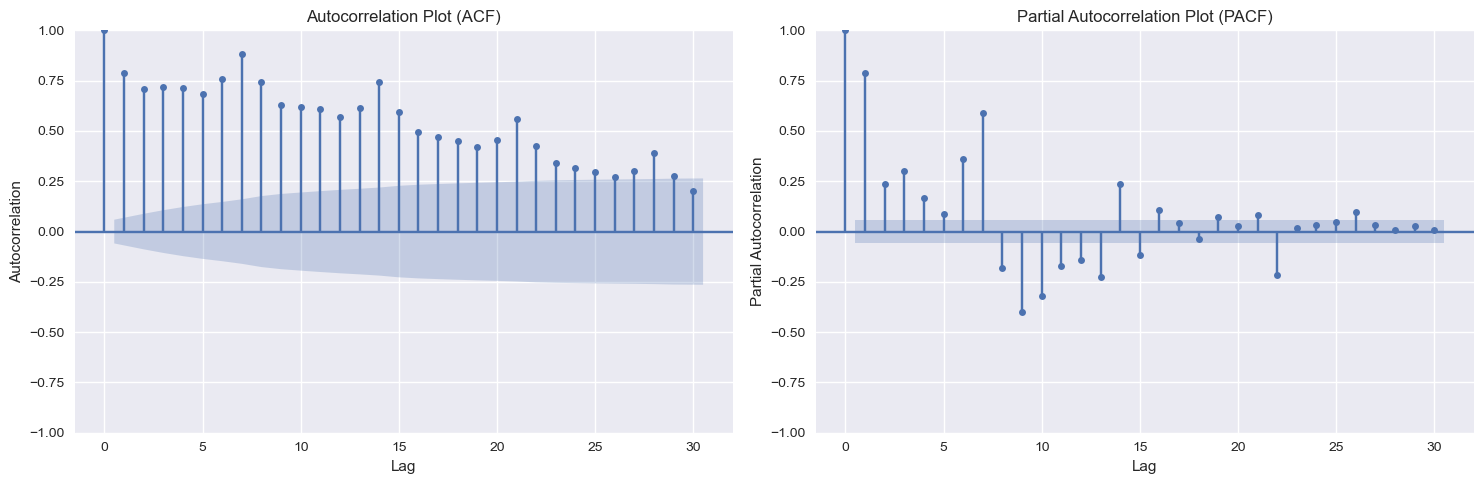

In [ ]:
# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(train_df['new_confirmed'].dropna(), lags=30, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(train_df['new_confirmed'].dropna(), lags=30, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


### <a id='toc3_2_1_'></a>[Base Arima Model](#toc0_)

In [ ]:
val_eval_holder = pd.DataFrame().rename_axis('Validation Metric', axis=1)
in_sample_eval_holder = pd.DataFrame().rename_axis('In-Sample Metric', axis=1)
out_of_sample_eval_holder = pd.DataFrame()


In [ ]:
# Flag to determine if the model should be trained or loaded from disk
training = True

# Check if the training flag is set to True
if training:
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    # and then fits an ARIMA model of order (10,0,9) to the transformed data.
    estimators = [
        ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
        ("model", pm.arima.ARIMA(order= (10,0,9), suppress_warnings=True)) # ARIMA model                   
                        ]
    pipeline = Pipeline(estimators)

else:
    # If not training, then load the pre-trained model from disk
    model_1 = joblib.load('models/ARIMA(10,0,9)(0,0,0)[0] intercept.pkl')
    print("model_1 loaded successfully")


0it [00:00, ?it/s]

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power



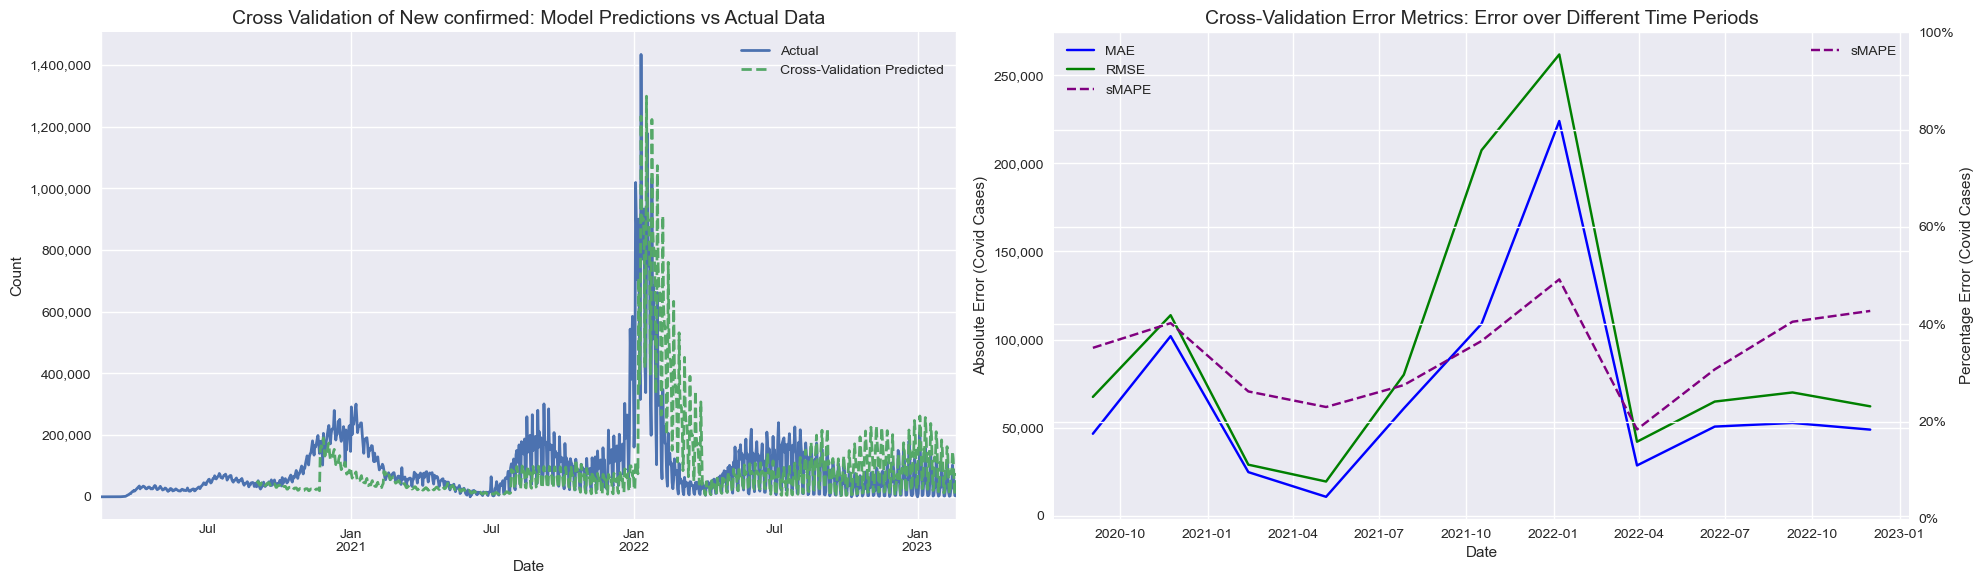

In [ ]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_1 = train_model(in_sample_set, pipeline, rolling_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, in_sample_set.name)


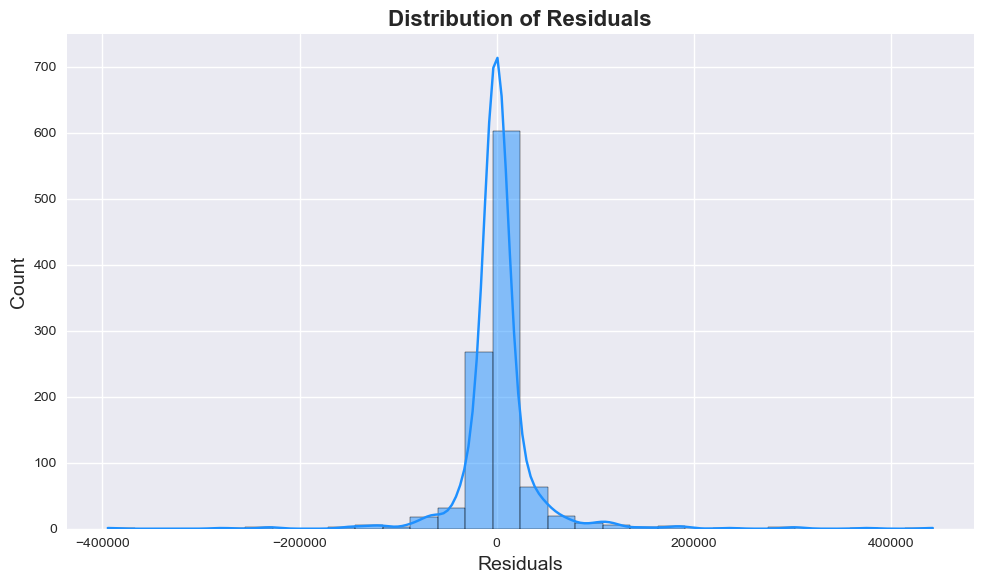

In [ ]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_1)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_1)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = str(model_1.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results



Validation Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]"
MAE,68996.045191,81120.693710
RMSE,92567.683406,104540.057312
sMAPE,33.663152,36.972139


In-Sample Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]","Seasonal ARIMA(10,0,1)(1,0,1)[31] intercept","Seasonal ARIMA(7,0,3)(2,0,1)[31] intercept"
R-squared,0.900879,0.838047,0.862919,0.837098
MAE,17927.644076,24954.668126,19622.023965,21156.649304
RMSE,41556.465370,53119.095201,48870.215409,53274.504510
sMAPE,10.553669,14.323993,11.363526,11.775650


In [ ]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_1, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_1.summary()

Model pickled to models/ARIMA(10,0,9)(0,0,0)[0] intercept.pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1102
Model:              SARIMAX(10, 0, 9)   Log Likelihood               -3970.108
Date:                Sun, 30 Jul 2023   AIC                           7982.217
Time:                        04:41:42   BIC                           8087.319
Sample:                             0   HQIC                          8021.974
                               - 1102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3217      0.253     13.150      0.000       2.827       3.817
ar.L1         -0.3727      0.110     -3.376      0.001      -0.589      -0.156
ar.L2          0.6603      0.076      8.716      0.000       0.512       0.809
ar.L3          0.5914      0.097      6.123      0.000       0.402       0.781
ar.L4          0.0872      0.026      3.419      0.001       0.037       0.137
ar.L5         -0.1086      0.026     -4.123      0.000      -0.160      -0.057
ar.L6          0.0583      0.028      2.062      0.039       0.003       0.114
ar.L7          0.9173      0.031     29.571      0.000       0.856       0.978
ar.L8          0.3599      0.092      3.914      0.000       0.180       0.540
ar.L9         -0.6267      0.049    -12.773      0.000      -0.723      -0.530
ar.L10        -0.6115      0.076     -8.076      0.000      -0.760      -0.463
ma.L1          0.6952      0.113      6.170      0.000       0.474       0.916
ma.L2          0.1183      0.114      1.036      0.300      -0.105       0.342
ma.L3         -0.1393      0.113     -1.230      0.219      -0.361       0.083
ma.L4         -0.2928      0.107     -2.737      0.006      -0.502      -0.083
ma.L5          0.0575      0.101      0.570      0.568      -0.140       0.255
ma.L6         -0.0963      0.089     -1.084      0.278      -0.270       0.078
ma.L7         -0.6711      0.095     -7.045      0.000      -0.858      -0.484
ma.L8         -0.4852      0.074     -6.518      0.000      -0.631      -0.339
ma.L9         -0.1862      0.038     -4.872      0.000      -0.261      -0.111
sigma2        58.2945      3.608     16.158      0.000      51.223      65.366
===================================================================================
Ljung-Box (L1) (Q):                  17.58   Jarque-Bera (JB):               570.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='toc3_2_2_'></a>[Tuned Arima Model](#toc0_)

In [ ]:
# Flag to determine if the model should be trained or loaded from disk
training = True


In [ ]:

# Check if the training flag is set to True
if training:
    # # If training is required:
    # estimators = [
    # ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
    # ("model", pm.auto_arima(in_sample_set))]  # Data for ARIMA model selection
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    # and then automatically determines the best ARIMA order within the given range using auto_arima.
    # estimators = [
    #     ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
    #     ("model", pm.auto_arima( in_sample_set,  # Data for ARIMA model selection
    #                     d=0,  # Differencing order
    #                     start_p=15,  # Initial AR order for search
    #                     start_q=5,   # Initial MA order for search
    #                     max_p=20,    # Maximum AR order for search
    #                     max_q=10,    # Maximum MA order for search
    #                     seasonal=False,  # No seasonal component
    #                     trace=True))]  # Print the search progress

    # pipeline = Pipeline(estimators)  # Construct the pipeline
    
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [16, 0, 6], 
                    seasonal=False,
                    suppress_warnings=True))                   
                    ]

    pipeline = Pipeline(estimators) 
    
else:
    # If not training, then load the pre-trained model from disk
    model_2 = joblib.load('models/ARIMA(16,0,6)(0,0,0)[0] intercept.pkl')
    print("model_2 loaded successfully")
    


0it [00:00, ?it/s]

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarn

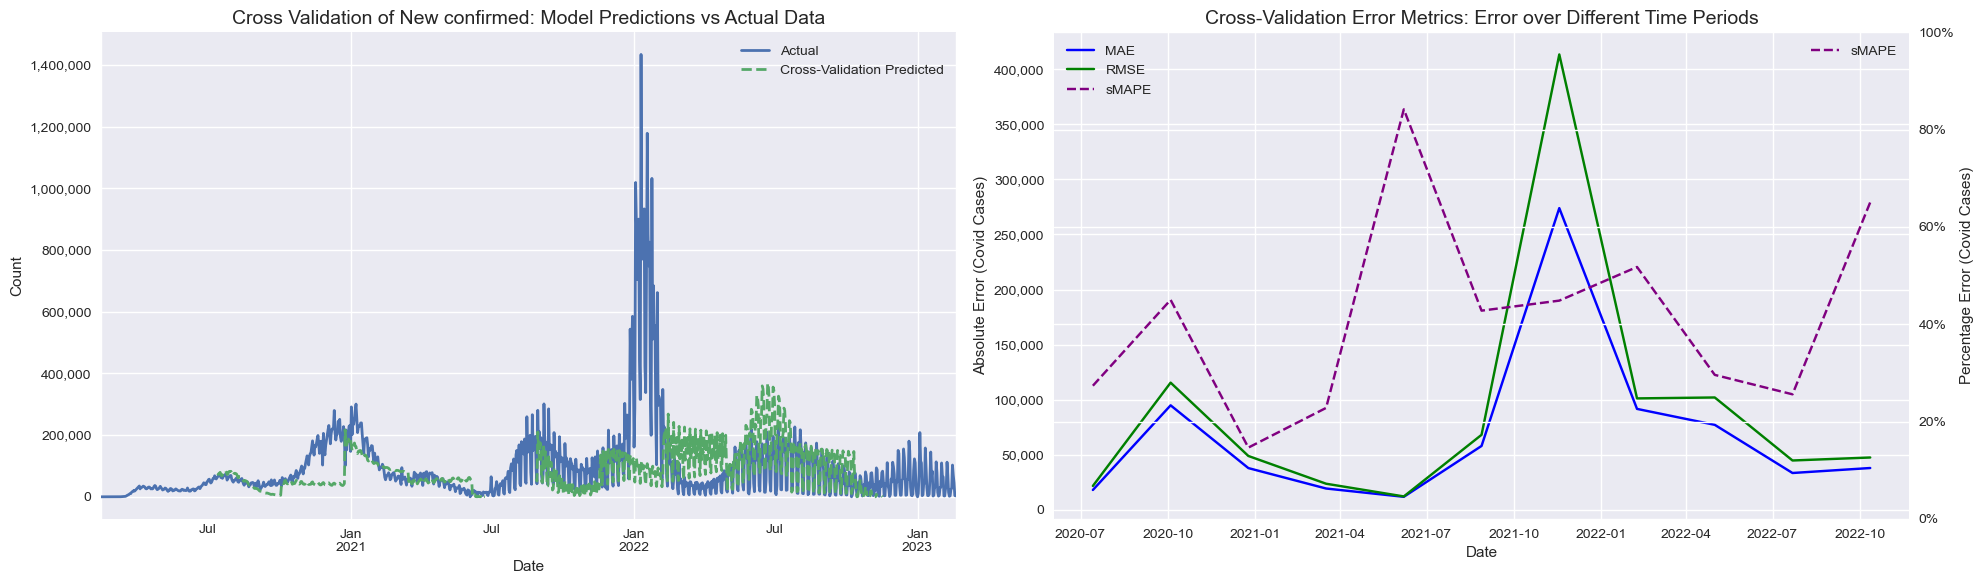

In [ ]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_2 = train_model(in_sample_set, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, in_sample_set.name)


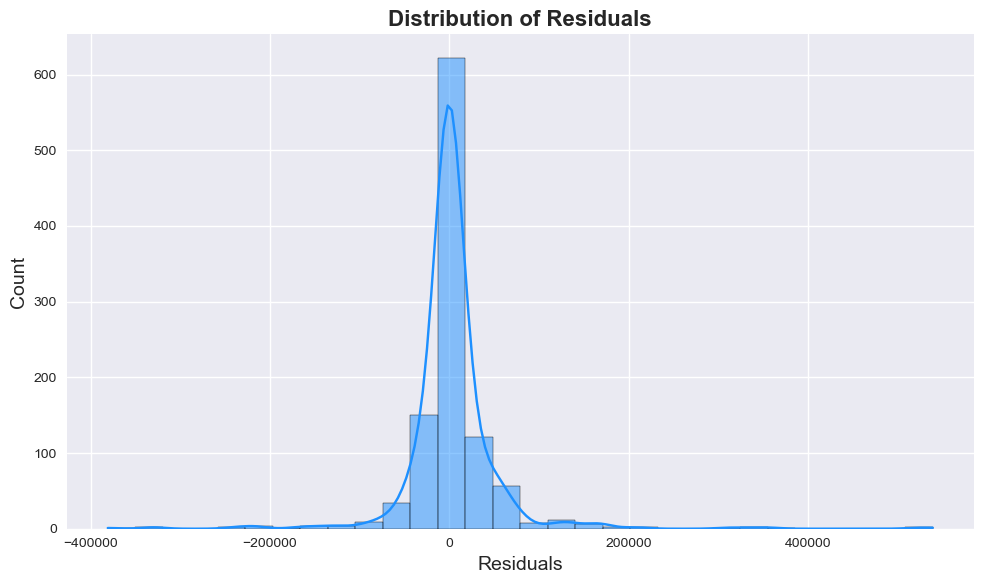

In [ ]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_2)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_2)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = str(model_2.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


Validation Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]"
MAE,71170.617362,81120.693710
RMSE,93966.778491,104540.057312
sMAPE,34.599939,36.972139


In-Sample Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]"
R-squared,0.833235,0.838047
MAE,26647.457402,24954.668126
RMSE,53902.510044,53119.095201
sMAPE,16.831398,14.323993


In [ ]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_2, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_2.summary()


Model pickled to models/ARIMA(5,1,2)(0,0,0)[0].pkl


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1102
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -3862.462
Date:                Sun, 30 Jul 2023   AIC                           7740.924
Time:                        04:42:03   BIC                           7780.956
Sample:                             0   HQIC                          7756.068
                               - 1102                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1260      0.027      4.701      0.000       0.073       0.178
ar.L2         -0.6135      0.022    -27.916      0.000      -0.657      -0.570
ar.L3         -0.3802      0.026    -14.410      0.000      -0.432      -0.328
ar.L4         -0.3552      0.019    -18.389      0.000      -0.393      -0.317
ar.L5         -0.5224      0.028    -18.893      0.000      -0.577      -0.468
ma.L1         -1.1193      0.018    -63.453      0.000      -1.154      -1.085
ma.L2          0.8330      0.017     48.839      0.000       0.800       0.866
sigma2        69.3675      2.057     33.724      0.000      65.336      73.399
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               436.12
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               6.35   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## <a id='toc3_3_'></a>[SARIMA](#toc0_)

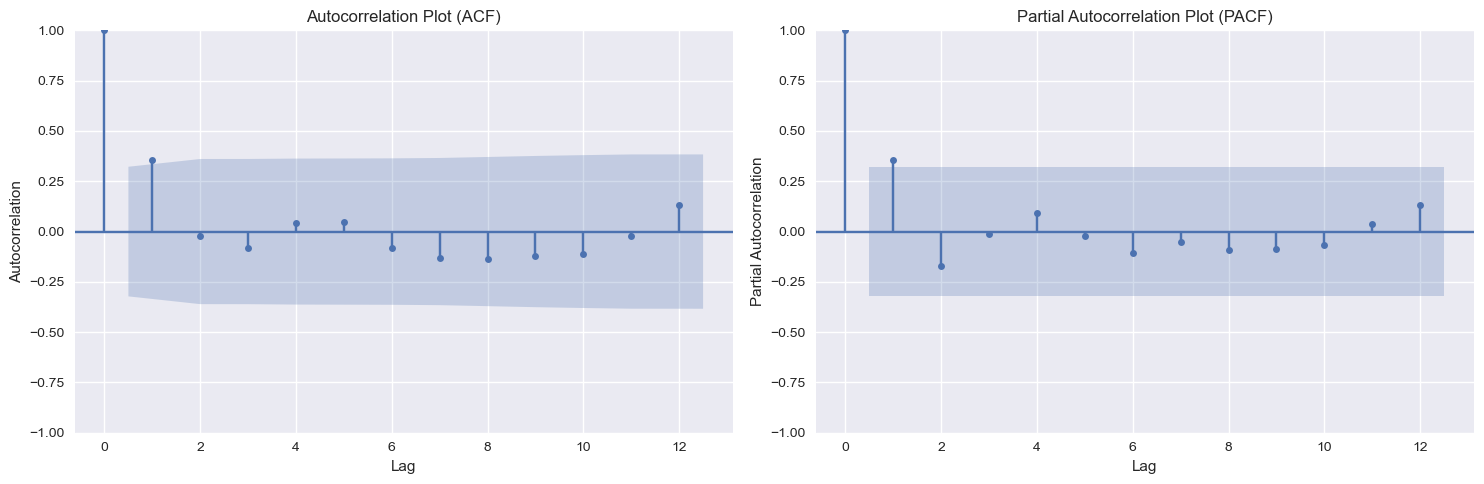

In [ ]:
other_interval = train_df.resample('MS').mean()

# Adjust the figure size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF
plot_acf(other_interval['new_confirmed'].dropna(), lags=len(other_interval)//3, ax=ax[0], title="Autocorrelation Plot (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid(True)
ax[0].tick_params(axis='both', which='major', labelsize=10)

# Plot PACF
plot_pacf(other_interval['new_confirmed'].dropna(), lags=len(other_interval)//3, ax=ax[1], title="Partial Autocorrelation Plot (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid(True)
ax[1].tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()


In [ ]:
check_stationarity(other_interval.new_confirmed)

Test Statistic                -4.039876
p-value                        0.001216
Number of Observations Used    0.000000
dtype: float64

### <a id='toc3_3_1_'></a>[Base SARIMA Model](#toc0_)

In [ ]:
# Flag to determine if the model should be trained or loaded from disk
training = True

# Check if the training flag is set to True
if training:
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [10, 0, 1], 
                    seasonal_order =[1, 0, 1, 31],
                    suppress_warnings=True))                   
                    ]

    pipeline = Pipeline(estimators) 

else:
    # If not training, then load the pre-trained model from disk
    model_3 = joblib.load('models/Seasonal ARIMA(10,0,1)(1,0,1)[31] intercept.pkl')
    print("model_3 loaded successfully")



model_3 loaded successfully


In [ ]:

if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_3 = train_model(in_sample_set, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, in_sample_set.name)


C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power



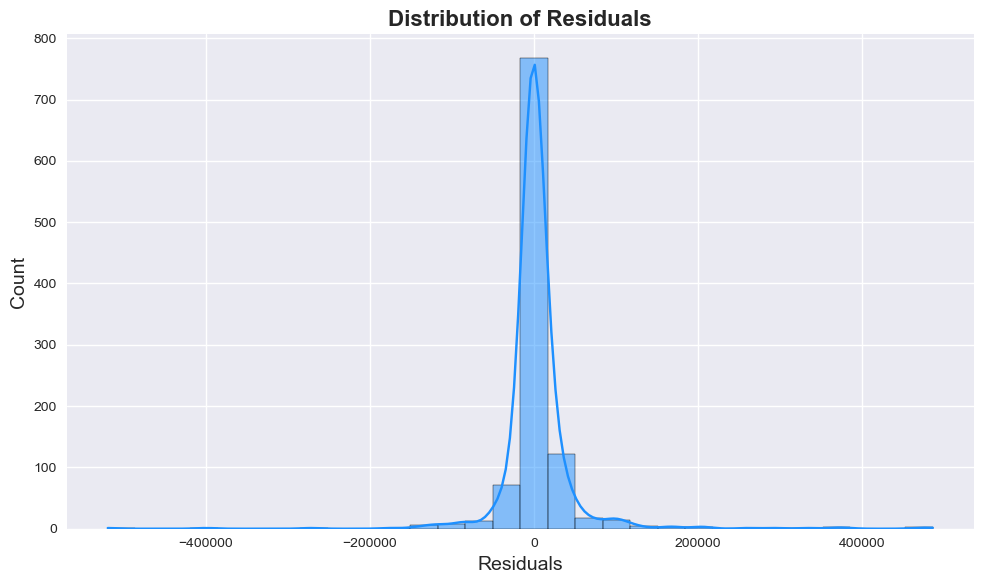

In [ ]:


# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_3)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_3)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Seasonal ' + str(model_3.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()

in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


Validation Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]"
MAE,71170.617362,81120.693710
RMSE,93966.778491,104540.057312
sMAPE,34.599939,36.972139


In-Sample Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]","Seasonal ARIMA(10,0,1)(1,0,1)[31] intercept"
R-squared,0.833235,0.838047,0.862919
MAE,26647.457402,24954.668126,19622.023965
RMSE,53902.510044,53119.095201,48870.215409
sMAPE,16.831398,14.323993,11.363526


In [ ]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"

    # Attempt to save the model to disk using pickling
    joblib.dump(model_3, pickle_tgt, compress=3)
    print("Model pickled to %s" % pickle_tgt)


# Display the summary of the trained model
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1102
Model:             SARIMAX(10, 0, 1)x(1, 0, 1, 31)   Log Likelihood               -3736.611
Date:                             Sun, 30 Jul 2023   AIC                           7503.222
Time:                                     04:44:39   BIC                           7578.295
Sample:                                          0   HQIC                          7531.620
                                            - 1102                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9549      2.457      0.389      0.698      -3.862       5.771
ar.L1          0.0171      0.189      0.090      0.928      -0.354       0.388
ar.L2          0.3067      0.058      5.316      0.000       0.194       0.420
ar.L3          0.1820      0.053      3.450      0.001       0.079       0.285
ar.L4          0.0235      0.017      1.369      0.171      -0.010       0.057
ar.L5         -0.0397      0.018     -2.244      0.025      -0.074      -0.005
ar.L6          0.1145      0.017      6.714      0.000       0.081       0.148
ar.L7          0.8119      0.026     31.095      0.000       0.761       0.863
ar.L8          0.0582      0.150      0.387      0.699      -0.236       0.353
ar.L9         -0.3066      0.038     -7.997      0.000      -0.382      -0.231
ar.L10        -0.2062      0.059     -3.504      0.000      -0.322      -0.091
ma.L1          0.2170      0.192      1.128      0.259      -0.160       0.594
ar.S.L31       0.6225      0.959      0.649      0.516      -1.257       2.503
ma.S.L31      -0.6388      0.948     -0.674      0.500      -2.497       1.219
sigma2        51.5661      1.251     41.223      0.000      49.114      54.018
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2307.79
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               6.17   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='toc3_3_2_'></a>[Tuned SARIMA Model](#toc0_)

In [ ]:
# Flag to determine if the model should be trained or loaded from disk
training = True

# # Check if the training flag is set to True
if training:
    # # If training is required:
    
    # # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    # # and then automatically determines the best ARIMA order within the given range using auto_arima.
    # estimators = [
    #     ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    #     ("model", pm.auto_arima(in_sample_set,
    #                     d=0,
    #                     start_p=10, 
    #                     max_p=12, 
    #                     max_q=3, 
    #                     max_P=3, 
    #                     max_Q=3,
    #                     D=0,
    #                     m=7,
    #                     seasonal=True, 
    #                     stationary=True,
    #                     trace=True))]

    # pipeline = Pipeline(estimators)
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [7, 0, 3], 
                    seasonal_order =[2, 0, 1, 31],
                    suppress_warnings=True))                   
                    ]

    pipeline = Pipeline(estimators) 


else:
    try:
        # If not training, then load the pre-trained model from disk
        model_4 = joblib.load('models/Seasonal ARIMA(7,0,3)(2,0,1)[31] intercept.pkl')
        print("model_4 loaded successfully")
    except:
        print("Error loading model_4")


model_4 loaded successfully


In [ ]:

if training:
    # If in training mode:

    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_4 = train_model(in_sample_set, pipeline, window_cv)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, in_sample_set.name)


C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\preprocessing\endog\boxcox.py:165: RuntimeWarning:

invalid value encountered in power



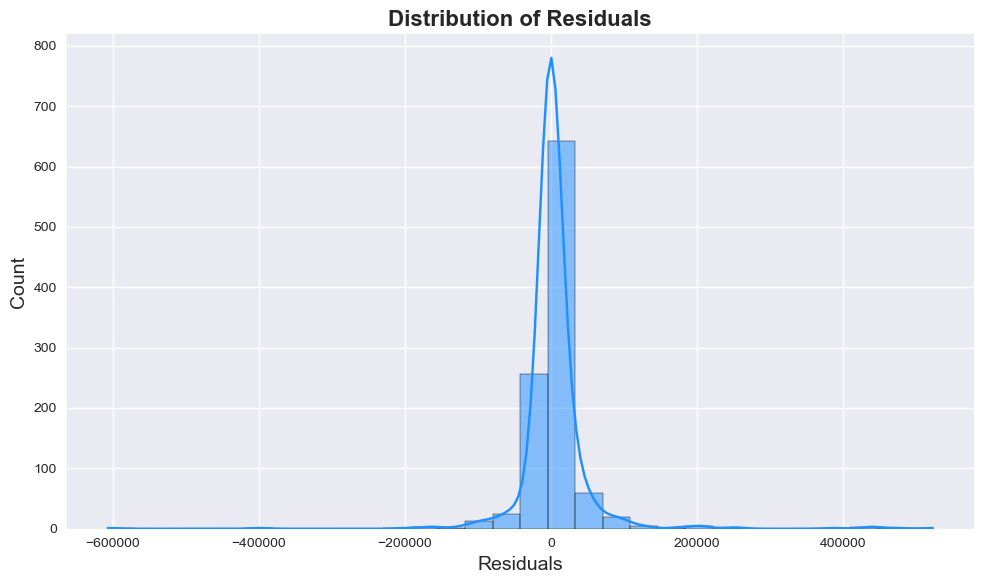

In [ ]:

# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_4)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_4)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Seasonal ' + str(model_4.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


Validation Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]"
MAE,71170.617362,81120.693710
RMSE,93966.778491,104540.057312
sMAPE,34.599939,36.972139


In-Sample Metric,"ARIMA(10,0,9)(0,0,0)[0] intercept","ARIMA(5,1,2)(0,0,0)[0]","Seasonal ARIMA(10,0,1)(1,0,1)[31] intercept","Seasonal ARIMA(7,0,3)(2,0,1)[31] intercept"
R-squared,0.833235,0.838047,0.862919,0.837098
MAE,26647.457402,24954.668126,19622.023965,21156.649304
RMSE,53902.510044,53119.095201,48870.215409,53274.504510
sMAPE,16.831398,14.323993,11.363526,11.775650


In [ ]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_4, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")

# Display the summary of the trained model
model_4.summary()

## <a id='toc3_4_'></a>[Sarimax](#toc0_)

In [ ]:
# import in variance inflation facctor test and add constant

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import RFE


In [ ]:
y_train = in_sample_set
y_test = out_of_sample_set

# # Assuming in_sample_set is a DataFrame
# X_train = train_df.drop(columns=['new_confirmed', 'confirmed','infected'])
# X_test = test_df.drop(columns=['new_confirmed', 'confirmed', 'infected'])

most_important = ['stringency_index', 'derived_reproduction_rate', 'total_vaccinations', 
                'current_hospitalized_patients',  'excess_mortality', 'month']

X_train = train_df[most_important]
X_test = test_df[['stringency_index', 'derived_reproduction_rate', 'current_hospitalized_patients',  
                'excess_mortality', 'month', 'new_bi_weekly_vaccinations']]

In [ ]:

# #Selecting the Best important features according to LGBMRegressor
rfe_selector = RFE(estimator=LGBMRegressor(), n_features_to_select = 7, step = 1)
rfe_selector.fit(X_train, y_train)


X_train = X_train.loc[:,X_train.columns[rfe_selector.get_support()]]
X_train.columns

Index(['stringency_index', 'derived_reproduction_rate', 'total_vaccinations',
       'current_hospitalized_patients', 'excess_mortality', 'month'],
      dtype='object')

In [ ]:
X_train = add_constant(X_train)

#  VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
display(vif_data.sort_values(by='VIF', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))


X_train.drop(columns=['const'], inplace=True)

,Feature,VIF
0,const,149.496895
5,excess_mortality,6.580612
1,stringency_index,5.898360
4,current_hospitalized_patients,5.560507
3,total_vaccinations,4.619215
2,derived_reproduction_rate,2.866390
6,month,1.417257


In [ ]:
for i in X_train.columns:
    print(i)
    test_stationarity(X_train[i], False)
    


stringency_index
Results of Dickey-Fuller Test:


Test Statistic                   -3.499147
p-value                           0.008009
#Lags Used                        7.000000
Number of Observations Used    1094.000000
Critical Value (1%)              -3.436342
Critical Value (5%)              -2.864186
Critical Value (10%)             -2.568179
dtype: float64

derived_reproduction_rate
Results of Dickey-Fuller Test:


Test Statistic                -7.636494e+00
p-value                        1.946180e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.098000e+03
Critical Value (1%)           -3.436320e+00
Critical Value (5%)           -2.864176e+00
Critical Value (10%)          -2.568173e+00
dtype: float64

total_vaccinations
Results of Dickey-Fuller Test:


Test Statistic                   -1.158045
p-value                           0.691378
#Lags Used                       22.000000
Number of Observations Used    1079.000000
Critical Value (1%)              -3.436425
Critical Value (5%)              -2.864222
Critical Value (10%)             -2.568198
dtype: float64

current_hospitalized_patients
Results of Dickey-Fuller Test:


Test Statistic                   -4.182947
p-value                           0.000704
#Lags Used                       21.000000
Number of Observations Used    1080.000000
Critical Value (1%)              -3.436419
Critical Value (5%)              -2.864220
Critical Value (10%)             -2.568197
dtype: float64

excess_mortality
Results of Dickey-Fuller Test:


Test Statistic                   -4.091615
p-value                           0.001000
#Lags Used                       21.000000
Number of Observations Used    1080.000000
Critical Value (1%)              -3.436419
Critical Value (5%)              -2.864220
Critical Value (10%)             -2.568197
dtype: float64

month
Results of Dickey-Fuller Test:


Test Statistic                   -2.888508
p-value                           0.046701
#Lags Used                        0.000000
Number of Observations Used    1101.000000
Critical Value (1%)              -3.436303
Critical Value (5%)              -2.864169
Critical Value (10%)             -2.568170
dtype: float64

In [ ]:
test_statistics = []
# Iterate over possible differencing levels from 1 to 19
for i in range(1, 20):
    # Difference the 'confirmed' series by the current level and drop NA values
    differenced_series = X_train['total_vaccinations'].diff(i).dropna()
    
    # Get the test statistic from the stationarity check and append to the list
    test_stat = check_stationarity(differenced_series).loc['Test Statistic']
    test_statistics.append(test_stat)

# Display the collected test statistics for each differencing level
for i, test_stat in enumerate(test_statistics, 1):
    print(f"Differencing Level {i}: Test Statistic = {test_stat:.2f}")

Differencing Level 1: Test Statistic = -2.13
Differencing Level 2: Test Statistic = -2.17
Differencing Level 3: Test Statistic = -2.33
Differencing Level 4: Test Statistic = -2.30
Differencing Level 5: Test Statistic = -2.44
Differencing Level 6: Test Statistic = -1.98
Differencing Level 7: Test Statistic = -2.14
Differencing Level 8: Test Statistic = -2.72
Differencing Level 9: Test Statistic = -2.40
Differencing Level 10: Test Statistic = -2.19
Differencing Level 11: Test Statistic = -2.11
Differencing Level 12: Test Statistic = -2.48
Differencing Level 13: Test Statistic = -2.71
Differencing Level 14: Test Statistic = -2.84
Differencing Level 15: Test Statistic = -3.73
Differencing Level 16: Test Statistic = -3.19
Differencing Level 17: Test Statistic = -2.73
Differencing Level 18: Test Statistic = -2.46
Differencing Level 19: Test Statistic = -2.52


In [ ]:
X_train['bi_weekly_vaccinations'] = X_train.loc[:,'total_vaccinations'].diff(15)
X_train.head(20)

,stringency_index,derived_reproduction_rate,total_vaccinations,current_hospitalized_patients,excess_mortality,month,bi_weekly_vaccinations
date,,,,,,,
2020-02-15,8.330000,35.466824,0.0,0.0,-2.363827,2,NaN
2020-02-16,8.330000,34.655106,0.0,0.0,-2.360000,2,NaN
2020-02-17,8.330000,33.889042,0.0,0.0,-2.294236,2,NaN
2020-02-18,8.330000,33.163906,0.0,0.0,-2.166535,2,NaN
2020-02-19,8.330000,32.475555,0.0,0.0,-1.976897,2,NaN
2020-02-20,8.330000,31.820343,0.0,0.0,-1.734526,2,NaN
2020-02-21,8.330000,31.195034,0.0,0.0,-1.494650,2,NaN
2020-02-22,8.330000,30.596754,0.0,0.0,-1.266475,2,NaN
2020-02-23,8.330000,30.022940,0.0,0.0,-1.050000,2,NaN


In [ ]:
X_train['bi_weekly_vaccinations'] = X_train['bi_weekly_vaccinations'].fillna(0)

In [ ]:
X_train = X_train.drop(columns='total_vaccinations')

In [ ]:
X_train = add_constant(X_train)

#  VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
display(vif_data.sort_values(by='VIF', ascending=False).style.background_gradient(cmap='coolwarm', vmax=10))


X_train.drop(columns=['const'], inplace=True)

,Feature,VIF
0,const,37.487801
4,excess_mortality,7.229920
3,current_hospitalized_patients,5.897228
1,stringency_index,1.874335
5,month,1.416740
2,derived_reproduction_rate,1.373373
6,bi_weekly_vaccinations,1.205258


### <a id='toc3_4_1_'></a>[Sarimax Base](#toc0_)

In [ ]:
# Flag to determine if the model should be trained or loaded from disk
training = True

# # Check if the training flag is set to True
if training:
    # # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [10, 0, 9], 
                    seasonal_order =[1, 0, 0, 14],
                    suppress_warnings=True))                   
                    ]
    
    
    pipeline = Pipeline(estimators) 

else:
    try:
        # If not training, then load the pre-trained model from disk
        model_5 = joblib.load('models/Exogenous ARIMA(10,0,9)(1,0,0)[14] intercept.pkl')
        print("model_5 loaded successfully")
    except:
        print("Error loading model_5")


In [ ]:
if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_5 = train_model(y_train, pipeline, window_cv, X_train)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)

    # pm.model_selection.cross_validate(pipeline, y_train, X_train, cv=window_cv, scoring='mean_squared_error')

In [ ]:


# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_5)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_5)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Exogenous ' + str(model_5.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()
    
in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


In [ ]:

if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_5, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_5.summary()

### <a id='toc3_4_2_'></a>[Tuned SARIMAX Model](#toc0_)

In [ ]:
def sarimax(ts,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(ts,
                        exog = exo,
                        order=param[0],
                        seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))



all_res = sarimax(y_train, X_train,all_param)
all_res

In [ ]:
# # Flag to determine if the model should be trained or loaded from disk
training = True

if training:
    # # # If training is required:
    
    # # # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    # # # and then automatically determines the best ARIMA order within the given range using auto_arima.
    # estimators = [
    #     ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    #     ("model", pm.auto_arima(y_train,
    #                     X_train,
    #                     m=14,
    #                     seasonal=True, 
    #                     stationary=True,
    #                     trace=True))]


    # pipeline = Pipeline(estimators)
    
    # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
    estimators = [
    ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
    ("model", pm.arima.ARIMA(order= [10, 0, 2], 
                    # seasonal_order =[2, 0, 1, 14],
                    suppress_warnings=True))               
                    ]

    pipeline = Pipeline(estimators) 

else:
    # If not training, then load the pre-trained model from disk
    model_6 = joblib.load('models/Exogenous ARIMA(10,0,2)(2,0,1)[14] intercept.pkl')
    print("model_6 loaded successfully")



In [ ]:
if training:
    # If in training mode:
    
    # Train the model using the specified pipeline and cross-validation window
    daily_values, val_scores, model_6 = train_model(y_train, pipeline, window_cv, X_train)

    # Visualize the model's performance on the validation set
    plot_combined_charts(daily_values, val_scores, y_train.name)



In [ ]:
# Visualize the model's in-sample predictions with confidence intervals
in_sample_scores = plot_predictions_with_confidence_interval(y_train, model_6)


In [ ]:

# Evaluate the model's forecasting performance on the out-of-sample data
test_scores = evaluate_forecast(y_train, y_test, model_6)


In [ ]:

# Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
model_name = 'Exogenous ' + str(model_6.steps[-1][1]).strip()

# Store evaluation metrics in their respective dictionaries
if training:
    val_eval_holder[model_name] = val_scores.mean()

in_sample_eval_holder[model_name] = in_sample_scores
out_of_sample_eval_holder[model_name] = test_scores

# Display evaluation results
if training:
    display(val_eval_holder)
display(in_sample_eval_holder)
# display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


In [ ]:
if training:
    # If in training mode:
    
    # Define the path where the trained model will be pickled (saved) to
    pickle_tgt = f"models/{model_name}.pkl"
    
    try:
        # Attempt to save the model to disk using pickling
        joblib.dump(model_6, pickle_tgt, compress=3)
        print("Model pickled to %s" % pickle_tgt)
        
    except:
        # If there's an error during pickling, display an error message
        print("Error pickling model")


# Display the summary of the trained model
model_6.summary()

## <a id='toc3_5_'></a>[Prophet Model](#toc0_)
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

### <a id='toc3_5_1_'></a>[Prophet Base](#toc0_)

In [ ]:
# Preparing data

# prophet_df = y_train.reset_index()[['date', 'new_confirmed']]
# prophet_df.columns = ['ds', 'y']

# # Create and fit model
# model.fit(prophet_df)

# def pipe_prophet(df, model, periods=7):
#     """Takes a dataframe with a date column and a y column, and a Prophet model.
#     Returns a dataframe with a date column and a yhat column, with the yhat
#     column containing the forecasted values for the next `periods` days.
#     """
#     # Create and fit model
#     model.fit(df)
#     # Create future dataframe
#     future = model.make_future_dataframe(periods=periods)
#     # Predict
#     forecast = model.predict(future)
#     # Return forecast
#     return forecast[['ds', 'yhat']]


transform_prophet = BoxCoxEndogTransformer(lmbda2=1e-6)
y_transformed = transform_prophet.fit_transform(y_train)[0]

prophet_df_transformed = pd.DataFrame(data = {'ds':y_train.index, "y":y_transformed})
prophet_df_transformed

,ds,y
0,2020-02-15,-3.707354
1,2020-02-16,-3.707354
2,2020-02-17,3.162945
3,2020-02-18,-3.707354
4,2020-02-19,-3.707354
...,...,...
1097,2023-02-16,67.598734
1098,2023-02-17,60.056157
1099,2023-02-18,29.962216
1100,2023-02-19,26.821497


In [ ]:

model = Prophet().fit(prophet_df_transformed)


05:04:28 - cmdstanpy - INFO - Chain [1] start processing
05:04:28 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:


df_cv2 = cross_validation(model, initial='800 days',period = '82', horizon='82 days', parallel="processes")

In [ ]:
df_cv2.head()


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='rmse')


In [ ]:

future = model.make_future_dataframe(periods=len(y_test))
forecast = model.predict(future)
model.plot(forecast);
sns.lineplot(data=y_test, label='Actual', color='red')


TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[int32]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int32]'>)

In [ ]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

with open('serialized_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model


In [ ]:
# # Flag to determine if the model should be trained or loaded from disk
# training = True

# # Check if the training flag is set to True
# if training:
    
#     # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
#     estimators = [
#         ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
#         ("model", REPLACETHIS)) # ARIMA model                   
#                         ]
#     pipeline = Pipeline(estimators)

# else:
#     # If not training, then load the pre-trained model from disk
#     REPLACETHIS = joblib.load('models/REPLACETHIS intercept.pkl')
#     print("REPLACETHIS loaded successfully")


# if training:
#     # If in training mode:
    
#     # Train the model using the specified pipeline and cross-validation window
#     daily_values, val_scores, REPLACETHIS = train_model(in_sample_set, pipeline, window_cv)

#     # Visualize the model's performance on the validation set
#     plot_combined_charts(daily_values, val_scores, in_sample_set.name)


# # Visualize the model's in-sample predictions with confidence intervals
# in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, REPLACETHIS)

# # Evaluate the model's forecasting performance on the out-of-sample data
# test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, REPLACETHIS)

# # Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
# model_name = str(REPLACETHIS.steps[-1][1]).strip()

# # Store evaluation metrics in their respective dictionaries
# val_eval_holder[model_name] = val_scores.mean()
# in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores

# # Display evaluation results
# display(val_eval_holder)
# display(in_sample_eval_holder)
# # display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


# if training:
#     # If in training mode:
    
#     # Define the path where the trained model will be pickled (saved) to
#     pickle_tgt = f"models/{model_name}.pkl"
    
#     try:
#         # Attempt to save the model to disk using pickling
#         joblib.dump(REPLACETHIS, pickle_tgt, compress=3)
#         print("Model pickled to %s" % pickle_tgt)
        
#     except:
#         # If there's an error during pickling, display an error message
#         print("Error pickling model")


# # Display the summary of the trained model
# REPLACETHIS.summary()

In [ ]:
ddddd

In [ ]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model


### <a id='toc3_5_2_'></a>[Prophet Tuned Model](#toc0_)

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(y_train)  # Fit model with given params
    df_cv = cross_validation(model, initial='800 days', period = '82', horizon='82 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=82)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
# # Flag to determine if the model should be trained or loaded from disk
# training = True

# # Check if the training flag is set to True
# if training:
    
#     # Initialize a pipeline that first applies a Box-Cox transformation to stabilize variance
#     estimators = [
#         ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),  # Box-Cox transformation
#         ("model", REPLACETHIS)) # ARIMA model                   
#                         ]
#     pipeline = Pipeline(estimators)

# else:
#     # If not training, then load the pre-trained model from disk
#     REPLACETHIS = joblib.load('models/REPLACETHIS intercept.pkl')
#     print("REPLACETHIS loaded successfully")


# if training:
#     # If in training mode:
    
#     # Train the model using the specified pipeline and cross-validation window
#     daily_values, val_scores, REPLACETHIS = train_model(in_sample_set, pipeline, window_cv)

#     # Visualize the model's performance on the validation set
#     plot_combined_charts(daily_values, val_scores, in_sample_set.name)


# # Visualize the model's in-sample predictions with confidence intervals
# in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, REPLACETHIS)

# # Evaluate the model's forecasting performance on the out-of-sample data
# test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, REPLACETHIS)

# # Extract the name of the model from the pipeline for use as a key in evaluation dictionaries
# model_name = str(REPLACETHIS.steps[-1][1]).strip()

# # Store evaluation metrics in their respective dictionaries
# val_eval_holder[model_name] = val_scores.mean()
# in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores

# # Display evaluation results
# display(val_eval_holder)
# display(in_sample_eval_holder)
# # display(out_of_sample_eval_holder)  # This line is commented; uncomment if you wish to display out-of-sample results


# if training:
#     # If in training mode:
    
#     # Define the path where the trained model will be pickled (saved) to
#     pickle_tgt = f"models/{model_name}.pkl"
    
#     try:
#         # Attempt to save the model to disk using pickling
#         joblib.dump(REPLACETHIS, pickle_tgt, compress=3)
#         print("Model pickled to %s" % pickle_tgt)
        
#     except:
#         # If there's an error during pickling, display an error message
#         print("Error pickling model")


# # Display the summary of the trained model
# REPLACETHIS.summary()

In [ ]:
# Format data for prophet model using ds and y
train_df_train_prophet = train_df.reset_index() \
    .rename(columns={'date':'ds',
                    'new_confirmed':'y'})
    


In [ ]:
%%time

# Predict on test set with model
train_df_test_prophet = test_df.reset_index() \
    .rename(columns={'date':'ds',
                    'new_confirmed':'y'})

forecast = model.predict(train_df_test_prophet)


from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast) # returns a plotly Figure object
fig.show()


fig = model.plot_components(train_df_test_fcst)
plt.show()


### <a id='toc3_5_3_'></a>[Facebook Prophet Analysis](#toc0_)

Facebook Prophet is designed for forecasting time series data. Let's see how we can use it.



#### <a id='toc3_5_3_1_'></a>[Preparing Data for Prophet](#toc0_)

Prophet requires the dataset to have two columns: `ds` and `y`, where `ds` is the timestamp and `y` is the value we want to predict.


In [ ]:
# Preparing data

prophet_df = y_train.reset_index()[['date', 'new_confirmed']]
prophet_df.columns = ['ds', 'y']

# Create and fit model
model = Prophet()
model.fit(prophet_df)

# Predictions
future = model.make_future_dataframe(periods=number_of_days_to_predict)
forecast = model.predict(future)
model.plot(forecast)




### <a id='toc3_5_4_'></a>[Recurrent Neural Networks (RNNs)](#toc0_)

RNNs are suitable for time series prediction due to their ability to recognize patterns in sequences of data.



#### <a id='toc3_5_4_1_'></a>[Data Preprocessing for RNNs](#toc0_)


In [ ]:


from sklearn.preprocessing import MinMaxScaler

data = train_df['new_confirmed'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for training
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])




#### <a id='toc3_5_4_2_'></a>[Building and Training the RNN](#toc0_)


In [ ]:


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)




#### <a id='toc3_5_4_3_'></a>[Predictions and Evaluation](#toc0_)


In [ ]:


scaled_predictions = model.predict(X_test)
predictions = scaler.inverse_transform(scaled_predictions)




---

This outline gives a clear walkthrough of the different steps involved in each method. Depending on the specific details of your dataset and the problem at hand, you might need to adjust and fine-tune some of these steps.

# <a id='toc4_'></a>[Code of the dead](#toc0_)

In [ ]:
# # estimators = [('scaler', None),
# #             ('feature_selection', None),
# #             ('dim_reducer', None),
# #             ('model', ARIMA())]

# # pipe = Pipeline(estimators) #, memory=cachedir

# # param_grid = {
# #     'model__p': list(range(16)),
# #     'model__d': list(range(3)),
# #     'model__q': list(range(16))
# # }

# # # 4. Split the dataset using TimeSeriesSplit
# # tscv = TimeSeriesSplit(n_splits=5)

# # # 5. Set up and run the GridSearchCV
# # gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_grid, verbose=1, n_jobs=-1)
# # gsearch.fit(train_df.index.values.reshape(-1, 1), train_df['new_confirmed'])

# # print(gsearch.best_params_)


# # best_score, best_cfg = float("inf"), None

# # GridSearchCV
# # for train_index, validation_index in tscv.split(train_df['new_confirmed']):
# #     train, test = train_df['new_confirmed'].iloc[train_index], train_df['new_confirmed'].iloc[validation_index]

# #     try:
# #         model = pm.auto_arima(train, start_p=1, start_q=1,
# #                         test='adf',       # use adftest to find optimal 'd'
# #                         max_p=15, max_q=3, # maximum p and q
# #                         m=1,              # frequency of series
# #                         d=None,           # let model determine 'd'
# #                         seasonal=False,   # No Seasonality
# #                         start_P=0, 
# #                         D=0, 
# #                         trace=True,
# #                         error_action='ignore',  
# #                         suppress_warnings=True, 
# #                         stepwise=True, 
# #                         stationary=True,
# #                         n_jobs=-1)
# #     except:
# #         continue
# #     predictions = model.predict(n_periods=len(test))
# #     mse = mean_squared_error(test, predictions)
    
# #     if mse < best_score:
# #         best_score, best_cfg = mse, (model.order, model.seasonal_order)
# #         best_model = model

# # print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# # best_model.summary()

# # gsearch = GridSearchCV(estimator=model, cv=tscv,
# #                         param_grid=param_search)
# # gsearch.fit(X, y)


# tscv = TimeSeriesSplit(n_splits=5)

# for train_index, validation_index in tscv.split(series['Confirmed']):


# model = pm.auto_arima(y= test_df['new_confirmed'], start_p=1, start_q=1,
#                     ['new_confirmed'], start_p=1, start_q=1,
#                     test='adf',       # use adftest to find optimal 'd'
#                     max_p=20, max_q=5, # maximum p and q
#                     m=1,              # frequency of series
#                     d=None,           # let model determine 'd'
#                     seasonal=False,   # No Seasonality
#                     start_P=0, 
#                     D=0, 
#                     trace=True,
#                     error_action='ignore',  
#                     suppress_warnings=True, 
#                     stepwise=True)

# print(model.summary())

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# import numpy as np
# X = np.array([[4, 5, 6, 1, 0, 2], [3.1, 3.5, 1.0, 2.1, 8.3, 1.1]]).T
# y = np.array([1, 6, 7, 1, 2, 3])

# model = ARIMA()
# param_search = {'max_depth' : [3, 5]}

# tscv = TimeSeriesSplit(n_splits=2)
# gsearch = GridSearchCV(estimator=model, cv=tscv,
#                         param_grid=param_search)
# gsearch.fit(X, y)

In [ ]:
# from statsmodels.tsa.x13 import x13_arima_analysis
# result = x13_arima_analysis(df['your_column_name'])
# print(result.seasadj)  # Seasonally adjusted series

# # Performing seasonal decomposition on 'new_confirmed' column
# decomposition = tsa.seasonal_decompose(train_df['current_hospitalized_patients'], model='additive', period=7)

# # Adding the decomposition data to the dataframe
# train_df["Hosp_Trend"] = decomposition.trend
# train_df["Hosp_Seasonal"] = decomposition.seasonal
# train_df["Hosp_Residual"] = decomposition.resid


# # Creating subplots for the trend, seasonal, and residual components
# cols = ["Hosp_Trend", "Hosp_Seasonal", "Hosp_Residual"]
# fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# for i, col in enumerate(cols):
#     fig.add_trace(go.Scatter(x=train_df.index, y=train_df[col], name=col), row=i+1, col=1)

# fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Hospitalized Patients')
# fig.show()

# # Performing seasonal decomposition on 'new_confirmed' column
# decomposition = tsa.seasonal_decompose(train_df['new_fatal'], model='additive', period=12)

# # Adding the decomposition data to the dataframe
# train_df["Fatal_Trend"] = decomposition.trend
# train_df["Fatal_Seasonal"] = decomposition.seasonal
# train_df["Fatal_Residual"] = decomposition.resid


# # Creating subplots for the trend, seasonal, and residual components
# cols = ["Fatal_Trend", "Fatal_Seasonal", "Fatal_Residual"]
# fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

# for i, col in enumerate(cols):
#     fig.add_trace(go.Scatter(x=train_df.index, y=train_df[col], name=col), row=i+1, col=1)

# fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Daily Fatalities')
# fig.show()


In [ ]:

# # Create a plot
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot MAPE as an area plot
# sns.lineplot(data=scores, x=scores.index, y='mape', ax=ax1, label='MAPE', alpha=0.5)
# ax1.fill_between(scores.index, 0, scores['mape'], alpha=0.5)

# # Create a second y-axis for RMSE and MAE
# ax2 = ax1.twinx()

# # Plot RMSE on the second y-axis
# sns.lineplot(data=scores, x=scores.index, y='rmse', ax=ax2, label='RMSE', color='red', linewidth=2)

# # Plot MAE on the second y-axis
# sns.lineplot(data=scores, x=scores.index, y='mae', ax=ax2, label='MAE', color='blue', linestyle='--', linewidth=2)

# # Set title, labels and legend
# ax1.set_title('Model Evaluation Metrics')
# ax1.set_xlabel('Metrics')
# ax1.set_ylabel('MAPE (Percentage of Error)')
# ax2.set_ylabel('RMSE / MAE (Cases Incorrectly Predicted)')

# # Format y-axes
# ax1.yaxis.set_major_formatter(PercentFormatter(100.0))
# ax2.yaxis.set_major_formatter(FuncFormatter(comma_format))

# # Display the legend
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show the plot
# plt.tight_layout()
# plt.show()


In [ ]:
# # # Even though we have a dedicated train/test split, we can (and should) still
# # # use cross-validation on our training set to get a good estimate of the model
# # # performance. We can choose which model is better based on how it performs
# # # over various folds.
# # model1 = pm.arima.ARIMA(order=(2, 1, 1), freq= 'D', suppress_warnings=True)
# # model2 = pm.arima.ARIMA(order=(1, 1, 2),
# #                 seasonal_order=(0, 1, 1, 12),
# #                 freq= 'D',
# #                 suppress_warnings=True)

# # cv = pm.model_selection.SlidingWindowForecastCV(window_size=300, step=200, h=30)

# # model1_cv_scores = pm.model_selection.cross_val_score(
# #     model1, train_df['confirmed'], scoring='smape', cv=cv, verbose=2)

# # model2_cv_scores = pm.model_selection.cross_val_score(
# #     model2, train_df['confirmed'], scoring='smape', cv=cv, verbose=2)

# # print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
# # print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))

# # # Pick based on which has a lower mean error rate
# # m1_average_error = np.average(model1_cv_scores)
# # m2_average_error = np.average(model2_cv_scores)
# # errors = [m1_average_error, m2_average_error]
# # models = [model1, model2]

# # # print out the answer
# # better_index = np.argmin(errors)  # type: int
# # print("Lowest average SMAPE: {} (model{})".format(
# #     errors[better_index], better_index + 1))
# # print("Best model: {}".format(models[better_index]))
# import itertools

# p = d = q = range(0,3)

# pdq = list(itertools.product(p,d,q))

# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

# ans = []

# for comb in pdq:
#     for combs in pdqs:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(train_df,
#                                         order=comb,
#                                         seasonal_order=combs,
#                                         freq='D')
#             output = mod.fit()
#             ans.append([comb, combs, output.aic])
#             print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        
#         except:
#             continue


# ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

# # # Capture the current time to measure the time taken by the grid search
# # start_time = time.time()

# # # Define a GridSearchCV object with the pipeline, parameter grid, and desired settings
# # grid = GridSearchCV(pipe, param_grid, return_train_score=True, 
# #                     cv=3, refit=True, verbose=1, n_jobs=-1, scoring=scoring_metric)


# # tss = TimeSeriesSplit(n_splits=5)

# # grid_search = GridSearchCV(pipe, grid, cv=tss, scoring='neg_mean_squared_error', verbose=1)
# # grid_search.fit(X, y)

# # best_model = grid_search.best_estimator_
# # best_rmse = np.sqrt(-grid_search.best_score_)

# # tss = TimeSeriesSplit(n_splits=5)
# # df = df.sort_index()



# # fold = 0
# # preds = []
# # scores = []
# # for train_idx, val_idx in tss.split(df):
# #         train = df.iloc[train_idx]
# #         test = df.iloc[val_idx]

# #         train = create_features(train)
# #         test = create_features(test)

# #         FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
# #                         'lag1','lag2','lag3']
# #         TARGET = 'PJME_MW'

# #         X_train = train[FEATURES]
# #         y_train = train[TARGET]

# #         X_test = test[FEATURES]
# #         y_test = test[TARGET]

# #         reg = CatBoostRegressor()
# #         reg.fit(X_train, y_train,
# #                 eval_set=[(X_train, y_train), (X_test, y_test)],
# #                 verbose=100)

# #         y_pred = reg.predict(X_test)
# #         preds.append(y_pred)
# #         score = np.sqrt(mean_squared_error(y_test, y_pred))
# #         scores.append(score)

# # print(f'Score across folds {np.mean(scores):0.4f}')
# # print(f'Fold scores:{scores}')

In [ ]:
# predictions1 = pm.model_selection.cross_val_predict(
#     pipeline, y, cv=rolling_cv, verbose=1, averaging="mean")

# # Plot the predictions over the original series
# x_axis = y.index
# n_test = predictions1.shape[0]

# predictions = pd.DataFrame(index = x_axis[-(n_test+2):], data = predictions1, columns = ['predictions'])

# df = pd.concat([predictions, y], axis=1)
# df
# # grouped = [np.sqrt(mean_squared_error(group.predictions, group.confirmed)) for _, group in df.resample('28D')]
# # hello = np.array(grouped)
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # Create a subplot layout with 2 rows and 1 column
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Percentage Errors (MAPE & SMAPE)', 'Absolute Errors (MAE & RMSE)'))

# # Plot for MAPE and SMAPE
# fig.add_trace(go.Scatter(x=df.index, y=df['mape']/100, fill='tozeroy', name='MAPE', mode='lines'), row=1, col=1)
# fig.add_trace(go.Scatter(x=df.index, y=df['smape']/100, mode='lines', name='SMAPE', line=dict(color='blue', dash='dash')), row=1, col=1)

# # Plot for MAE and RMSE
# fig.add_trace(go.Scatter(x=df.index, y=df['mae'], mode='lines', name='MAE'), row=1, col=1, secondary_y=True)
# fig.add_trace(go.Scatter(x=df.index, y=df['rmse'], mode='lines', name='RMSE', line=dict(color='red')), row=1, col=1, secondary_y=True)

# # Update layout and y-axis formats
# fig.update_layout(title_text="Model Evaluation Metrics", showlegend=True)
# fig.update_yaxes(tickformat="0%", row=1, col=1)  # Format the y-axis of the first subplot as percentages

# # Display the figure
# fig.show()


In [ ]:

# def generate_daily_metrics(model_preds, actual):
#     """
#     Generate various metrics and performance data from the predictions.
    
#     Parameters:
#     - plot_df: DataFrame containing the model predictions and actual data.
#     - actual: Actual values to compare against the predictions.
    
#     Returns:
#     - plot_df: DataFrame updated with the new metrics.
#     """
    
#     plot_df = pd.DataFrame({'predicted': model_preds, 'confirmed': actual})
#     plot_df['daily_predicted'] = plot_df['predicted'].diff()
#     plot_df['daily_confirmed'] = plot_df['confirmed'].diff()
#     plot_df['rmse'] = np.sqrt((plot_df['confirmed'] - plot_df['predicted'])**2)
#     plot_df['mae'] = np.abs(plot_df['confirmed'] - plot_df['predicted'])
#     plot_df['mape'] = 100 * np.abs(plot_df['confirmed'] - plot_df['predicted']) / np.abs(actual)
#     plot_df['smape'] =  100 * np.abs(plot_df['confirmed'] - plot_df['predicted']) / (np.abs(actual) + np.abs(plot_df['predicted']))
    
#     return plot_df



In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(data=features_and_target.dropna(),
#             x='year',
#             y='new_confirmed',
#             hue='season',
#             ax=ax,
#             linewidth=1,
#             showfliers=False)
# ax.set_title('Confirmed by Month of the Year')
# ax.set_xlabel('Month of the Year')
# ax.set_ylabel('COVID New Cases')
# ax.set_ylim(0, 800000)
# ax.legend(bbox_to_anchor=(1, 1))
# plt.show()

In [ ]:
# training = True

# if training:
#     # Define the pipeline
#     estimators = [
#         ("boxcox", BoxCoxEndogTransformer(lmbda2=1e-6)),
#         ("model", pm.arima.ARIMA(order= (10,0,9), 
#                         suppress_warnings=True))                   
#                         ]

#     pipeline = Pipeline(estimators)

# else:
#     model_1 = joblib.load('models/ARIMA(10,0,9)(0,0,0)[0] intercept.pkl')
#     print("model_1 loaded successfully")
    

# if training:
#     # Train the model
#     daily_values, val_scores, model_1 = train_model(in_sample_set, pipeline, window_cv)

#     # Plot Overall Validation Set Performance
#     plot_combined_charts(daily_values, val_scores, in_sample_set.name)

# # Plot Overall In Sample Set Performance
# in_sample_scores = plot_predictions_with_confidence_interval(in_sample_set, model_1)

# # Evaluate the forecast and Residuals Optional
# test_scores = evaluate_forecast(in_sample_set, out_of_sample_set, model_1)


# model_name = str(model_1.steps[-1][1]).strip()

# val_eval_holder[model_name] = val_scores.mean()
# in_sample_eval_holder[model_name] = in_sample_scores
# out_of_sample_eval_holder[model_name] = test_scores


# display(val_eval_holder)
# display(in_sample_eval_holder)
# # display(out_of_sample_eval_holder)

# model_1.summary()

# if training:
#     pickle_tgt = f"models/{model_name}.pkl"
#     try:
#         # Pickle it
#         joblib.dump(model, pickle_tgt, compress=3)
#         print("Model pickled to %s" % pickle_tgt)
        
#     except:
#         print("Error pickling model")
        